# Импорты

In [ ]:
!apt-get update
!apt-get install -y chromium-chromedriver
!pip install selenium webdriver-manager beautifulsoup4 pandas

!pip install selenium
!pip install selenium webdriver-manager
!pip install requests beautifulsoup4 pandas fake-useragent
!pip install --upgrade webdriver-manager

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [77.5 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,659 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,245 kB]
Hit:13 htt

In [ ]:
import requests
import csv
import time
import random
import csv
import pandas as pd
import re
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.stats.diagnostic as sms
from statsmodels.tools.tools import add_constant
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import Lasso, Ridge
from statsmodels.regression.quantile_regression import QuantReg
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
from tqdm import tqdm
from bs4 import BeautifulSoup
from lxml import html
from google.colab import files
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium import webdriver
from statsmodels.tools.tools import add_constant
from selenium.webdriver.chrome.options import Options

ModuleNotFoundError: No module named 'selenium'

# Парсинг

In [ ]:
# Настройка ChromeOptions
options = Options()
options.add_argument('--headless=new')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-gpu')
options.binary_location = '/usr/bin/chromium-browser'

data = []

try:
    driver = webdriver.Chrome(options=options)
    base_url = "https://teaco.ru/catalog/chay/"
    base_domain = "https://teaco.ru"

    for page in range(1, 17):
        url = f"{base_url}?PAGEN_1={page}" if page > 1 else base_url
        driver.get(url)
        print("Обрабатываю страницу ", page, "...")

        WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.CLASS_NAME, "catalog-card-item"))
        )

        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)

        products = driver.find_elements(By.CLASS_NAME, "catalog-card-item")

        for product in products:
            try:
                title = product.find_element(By.CLASS_NAME, "catalog-card-title").text
                price = product.find_element(By.CLASS_NAME, "catalog-card-price-wrapper").text
                price_cut = price.replace(" ₽", "").replace(" ", "")
                weight = product.find_element(By.CLASS_NAME, "catalog-card-weight").text
                weight_cut = weight.replace("Вес: ", "").replace(" г", "").replace(" ", "")

                product_link_element = product.find_element(By.CSS_SELECTOR, "a.catalog-card-title")
                product_href = product_link_element.get_attribute("href")

                if not product_href.startswith(("http://", "https://")):
                    product_href = base_domain + product_href

                driver.execute_script("window.open('');")
                driver.switch_to.window(driver.window_handles[1])
                driver.get(product_href)

                try:
                    reg = WebDriverWait(driver, 7).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, ".product-region"))
                    ).text
                except:
                    reg = "Нет данных"

                try:
                    des = WebDriverWait(driver, 7).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, ".detail-text"))
                    ).text
                except:
                    des = "Нет данных"

                accordion_data = {}
                try:
                    accordion_list = WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.CLASS_NAME, "accordion-list"))
                    )
                    items = accordion_list.find_elements(By.CLASS_NAME, "accordion-item")

                    for item in items:
                        try:
                            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", item)

                            trigger = item.find_element(By.CLASS_NAME, "accordion-trigger")
                            section_title = trigger.text.strip()
                            inner = item.find_element(By.CLASS_NAME, "accordion-inner")

                            if "display: none" in inner.get_attribute("style"):
                                driver.execute_script("arguments[0].click();", trigger)

                                WebDriverWait(driver, 10).until(
                                    lambda d: "display: none" not in inner.get_attribute("style") and
                                    inner.is_displayed() and
                                    inner.size['height'] > 10
                                )
                                time.sleep(0.3)

                            content = ""
                            try:
                                paragraphs = inner.find_elements(By.XPATH, ".//*[self::p or self::div or self::span][normalize-space()]")
                                content = "\n".join([p.text.strip() for p in paragraphs if p.text.strip()])
                                if not content:
                                    content = inner.get_attribute("textContent").strip()
                            except:
                                content = inner.get_attribute("innerText").strip()

                            accordion_data[section_title] = content

                            if "display: none" not in inner.get_attribute("style"):
                                driver.execute_script("arguments[0].click();", trigger)
                                time.sleep(0.2)

                        except Exception as e:
                            print("Ошибка при обработке секции ", section_title, ": ", str(e))
                            continue

                    comp = accordion_data.get("Состав", "Нет данных")

                except Exception as e:
                    print("Ошибка при обработке аккордеонов: ", str(e))
                    comp = "Нет данных"

                driver.close()
                driver.switch_to.window(driver.window_handles[0])

                product_data = {
                    "Страница": page,
                    "Название": title,
                    "Цена за грамм (₽/г)": int(price_cut) / int(weight_cut),
                    "Описание": des,
                    "Регион": reg,
                    "Ссылка": product_href,
                }

                product_data.update({f"Аккордеон: {k}": v for k, v in accordion_data.items() if k != "Состав"})

                data.append(product_data)

            except Exception as e:
                print("Ошибка при обработке товара ", title if 'title' in locals() else 'Unknown', ": ", str(e))
                if len(driver.window_handles) > 1:
                    driver.switch_to.window(driver.window_handles[1])
                    driver.close()
                    driver.switch_to.window(driver.window_handles[0])
                continue

    data = pd.DataFrame(data)
    print("\nГотово! Собрано", len(data), "товаров.")

except Exception as e:
    print("Ошибка: ", str(e))
    if 'driver' in locals():
        driver.save_screenshot("error_screenshot.png")
finally:
    if 'driver' in locals():
        driver.quit()

Обрабатываю страницу  1 ...
Обрабатываю страницу  2 ...
Обрабатываю страницу  3 ...
Обрабатываю страницу  4 ...
Обрабатываю страницу  5 ...
Обрабатываю страницу  6 ...
Обрабатываю страницу  7 ...
Обрабатываю страницу  8 ...
Обрабатываю страницу  9 ...
Обрабатываю страницу  10 ...
Обрабатываю страницу  11 ...
Обрабатываю страницу  12 ...
Обрабатываю страницу  13 ...
Обрабатываю страницу  14 ...
Обрабатываю страницу  15 ...
Обрабатываю страницу  16 ...

Готово! Собрано 240 товаров.


In [ ]:
data.head()

,Страница,Название,Цена за грамм (₽/г),Описание,Регион,Ссылка,"Аккордеон: ЦВЕТ, АРОМАТ И ВКУС",Аккордеон: СОСТАВ,Аккордеон: КОЛИЧЕСТВО В УПАКОВКЕ,Аккордеон: ВЕС ПАКЕТИКА (Г)
0,1,АЛТАЙСКИЙ БАЛЬЗАМ,4.652000,"Авторская смесь, гармонично сочетающая в себе ...",Россия,https://teaco.ru/catalog/chay/fruktovo-yagodny...,"ВкусНезначительная терпкость, умеренная кислот...","шиповник, Облепиха целая сублимированная, зизи...",NaN,NaN
1,1,АЛТАЙСКИЙ ИВАН-ЧАЙ С САГАН ДАЙЛЯ И БРУСНИКОЙ,9.940000,"Авторский бодрящий купаж, при этом совершенно ...",Россия,https://teaco.ru/catalog/chay/ivan-chay/altays...,"ВкусЗначительная терпкость, умеренная кислотно...","иван-чай черный, сушеная клюква, лист брусники...",NaN,NaN
2,1,АРОМАТНЫЙ ЖАСМИН,5.928000,Классический зеленый чай естественной ароматиз...,Китай,https://teaco.ru/catalog/chay/zelenyy-chay-s-d...,"ВкусСредняя терпкость, умеренная кислотность, ...",чай зеленый жасминовый,NaN,NaN
3,1,АССАМ №12,2.728000,Индийский черный чай мелкой фракции с золотыми...,Индия,https://teaco.ru/catalog/chay/chernyy-chay/ass...,"ВкусЗначительная терпкость, умеренная кислотно...",чай черный,NaN,NaN
4,1,АССАМ №24,2.426667,Традиционный индийский черный чай. Готовый нап...,Индия,https://teaco.ru/catalog/chay/chernyy-chay/che...,"ВкусЗначительная терпкость, умеренная кислотно...",чай черный,NaN,NaN


In [ ]:
data.to_csv('tea_catalog_all_pages.csv', index=False, encoding='utf-8-sig')
files.download('tea_catalog_all_pages.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Подготовка dataframe

In [ ]:
df = pd.read_csv('tea_catalog_all_pages.csv')
df.head()

,Страница,Название,Цена за грамм (₽/г),Описание,Регион,Ссылка,"Аккордеон: ЦВЕТ, АРОМАТ И ВКУС",Аккордеон: СОСТАВ,Аккордеон: КОЛИЧЕСТВО В УПАКОВКЕ,Аккордеон: ВЕС ПАКЕТИКА (Г)
0,1,АЛТАЙСКИЙ БАЛЬЗАМ,4.652000,"Авторская смесь, гармонично сочетающая в себе ...",Россия,https://teaco.ru/catalog/chay/fruktovo-yagodny...,"ВкусНезначительная терпкость, умеренная кислот...","шиповник, Облепиха целая сублимированная, зизи...",NaN,NaN
1,1,АЛТАЙСКИЙ ИВАН-ЧАЙ С САГАН ДАЙЛЯ И БРУСНИКОЙ,9.940000,"Авторский бодрящий купаж, при этом совершенно ...",Россия,https://teaco.ru/catalog/chay/ivan-chay/altays...,"ВкусЗначительная терпкость, умеренная кислотно...","иван-чай черный, сушеная клюква, лист брусники...",NaN,NaN
2,1,АРОМАТНЫЙ ЖАСМИН,5.928000,Классический зеленый чай естественной ароматиз...,Китай,https://teaco.ru/catalog/chay/zelenyy-chay-s-d...,"ВкусСредняя терпкость, умеренная кислотность, ...",чай зеленый жасминовый,NaN,NaN
3,1,АССАМ №12,2.728000,Индийский черный чай мелкой фракции с золотыми...,Индия,https://teaco.ru/catalog/chay/chernyy-chay/ass...,"ВкусЗначительная терпкость, умеренная кислотно...",чай черный,NaN,NaN
4,1,АССАМ №24,2.426667,Традиционный индийский черный чай. Готовый нап...,Индия,https://teaco.ru/catalog/chay/chernyy-chay/che...,"ВкусЗначительная терпкость, умеренная кислотно...",чай черный,NaN,NaN


In [ ]:
df2 = pd.DataFrame()

In [ ]:
def extract_aftertaste(text):
    if not isinstance(text, str):
        return None
    # "послевкусие – <описание>"
    match1 = re.search(
        r'послевкусие\s*[–-]\s*([^.]*?)(?=\s*(\.|Аромат|Цвет|$))',
        text,
        flags=re.IGNORECASE
    )
    if match1:
        return match1.group(1).strip()
    # "послевкусием ... "
    match2 = re.search(
        r'послевкусием\s+([^.]*?)(?=\s*(\.|Аромат|Цвет|$))',
        text,
        flags=re.IGNORECASE
    )
    if match2:
        return match2.group(1).strip()
    # "в послевкусии - ..."
    match3 = re.search(
        r'в послевкусии\s*[–-]\s*([^.]*?)(?=\s*(\.|Аромат|Цвет|$))',
        text,
        flags=re.IGNORECASE
    )
    if match3:
        return match3.group(1).strip()
    return None

In [ ]:
def create_flavor_features(text):
    if not isinstance(text, str):
        return {
            'Продолжительное послевкусие': 0,
            'Кислота': 0,
            'Горечь': 0,
            'Сладкость': 0,
            'Фрукты': 0,
            'Цветы': 0,
            'Травы': 0,
            'Острота': 0,
            'Орехи': 0
        }
    features = {
        'Продолжительное послевкусие': int(any(word in text for word in ['продолжительное', 'долгое', 'стойкое'])),
        'Кислота': int(any(word in text for word in ['кислинкой', 'кислотность', 'кислых'])),
        'Горечь': int(any(word in text for word in ['горчинкой', 'горечь', 'терпкость'])),
        'Сладкость': int(any(word in text for word in ['сладкими', 'сладкое', 'меда', 'карамели'])),
        'Фрукты': int(any(word in text for word in ['фруктовые', 'ягодным', 'цитрусовыми'])),
        'Цветы': int(any(word in text for word in ['цветочными', 'жасмина', 'цветочные'])),
        'Травы': int(any(word in text for word in ['травяные', 'растительными', 'ментоловым'])),
        'Острота': int(any(word in text for word in ['пряными', 'имбиря', 'жгучестью'])),
        'Орехи': int(any(word in text for word in ['орех', 'ореховых', 'миндальными']))
    }
    return features

In [ ]:
def extract_intensity(text):
    if not isinstance(text, str):
        return 0
    intensity_words = {
        'слаб': 1,
        'умерен': 2,
        'выражен': 3,
        'ярк': 4,
        'интенсивн': 5,
        'мощн': 6
    }
    for word, score in intensity_words.items():
        if word in text.lower():
            return score
    return 2

In [ ]:
df2['Название']=df['Название']

# таргет
df2['Цена за грамм (₽/г)']=df['Цена за грамм (₽/г)']

# счетная переменная для кол-ва ингредиентов
df2['Количество ингредиентов'] = df['Аккордеон: СОСТАВ'].str.count(',')+1

# бинарные переменные на страну, базовая группа - 'нет данных'
# [('россия', 132),('китай', 40), ('нет данных', 39), ('шри ланка', 9),('индия', 8), ('юар', 6), ('тайвань', 6)]
df2['Россия']=(df['Регион'] == 'Россия').astype(int)
df2['Китай']=(df['Регион'] == 'Китай').astype(int)
df2['Индия']=(df['Регион'] == 'Индия').astype(int)
df2['Тайвань']=(df['Регион'] == 'Тайвань').astype(int)
df2['Шри-Ланка']=(df['Регион'] == 'Шри-Ланка').astype(int)
df2['ЮАР']=(df['Регион'] == 'ЮАР').astype(int)

# бинарная переменная, 1 - купаж, 0 - не купаж
df2['Купаж'] = df['Описание'].str.contains(r'\bкупаж[а-я]*\b', case=False, regex=True, na=False).astype(int)

# бинарная переменная, 1 - ароматизатор есть, 0 - ароматизатора нет
df2['Содержит ароматизатор'] = df['Аккордеон: СОСТАВ'].str.contains(r'\bароматизатор[а-я]*\b', case=False, regex=True, na=False).astype(int)

# бинарная переменная, 1 - непакетированный, 0 - пакетированный
df2['Непакетированный'] = df['Аккордеон: КОЛИЧЕСТВО В УПАКОВКЕ'].isna().astype(int)

# две бинарные переменные на прозрачность, так как есть чай, у которого обе переменные принимают значение 0
df2['Прозрачный'] = df['Аккордеон: ЦВЕТ, АРОМАТ И ВКУС'].str.contains(r'\bпрозрачный\b', case=False, regex=True, na=False).astype(int)
df2['Непрозрачный'] = df['Аккордеон: ЦВЕТ, АРОМАТ И ВКУС'].str.contains(r'\bнепрозрачный\b', case=False, regex=True, na=False).astype(int)

# две бинарные переменные на интенсивность, так как есть чай, у которого обе переменные принимают значение 0
df2['Интенсивный'] = df['Аккордеон: ЦВЕТ, АРОМАТ И ВКУС'].str.contains(r'\bинтенсивный\b', case=False, regex=True, na=False).astype(int)
df2['Неинтенсивный'] = df['Аккордеон: ЦВЕТ, АРОМАТ И ВКУС'].str.contains(r'\bнеинтенсивный\b', case=False, regex=True, na=False).astype(int)

# переменная на терпкость
n1 = 'незначительная терпкость' # 1
n2 = 'средняя терпкость'        # 2
n3 = 'значительная терпкость'   # 3
n4 = 'терпкий терпкость'        # 4
n5 = 'высокая терпкость'        # 5
ds = []
for text in df['Аккордеон: ЦВЕТ, АРОМАТ И ВКУС']:
    text_lower = str(text).lower()
    if n1 in text_lower:
        ds.append(1)
    elif n2 in text_lower:
        ds.append(2)
    elif n3 in text_lower:
        ds.append(3)
    elif n4 in text_lower:
        ds.append(4)
    elif n5 in text_lower:
        ds.append(5)
    else:
        ds.append(0)
df2['Терпкость'] = ds

# переменная на кислотность
n1 = 'умеренная кислотность'  # 1
n2 = 'средняя кислотность'    # 2
n3 = 'высокая кислотность'    # 3
ds = []
for text in df['Аккордеон: ЦВЕТ, АРОМАТ И ВКУС']:
    text_lower = str(text).lower()
    if n1 in text_lower:
        ds.append(1)
    elif n2 in text_lower:
        ds.append(2)
    elif n3 in text_lower:
        ds.append(3)
    else:
        ds.append(0)
df2['Кислотность'] = ds

# послевкусие - вспомогательная колонка, из которой потом будем доставать другие переменные
df2['Послевкусие'] = df['Аккордеон: ЦВЕТ, АРОМАТ И ВКУС'].apply(extract_aftertaste)

# бинарные переменные изи послевкусия: 'Продолжительное послевкусие', 'Кислота', 'Горечь', 'Сладкость', 'Фрукты', 'Цветы', 'Травы', 'Острота', 'Орехи'
flavor_features = df2['Послевкусие'].apply(create_flavor_features).apply(pd.Series)
flavor_features = flavor_features.apply(pd.to_numeric, errors='coerce').fillna(0)
df2 = pd.concat([df2, flavor_features], axis=1)

# интенсивность послевкусия
# 'слаб': 1, 'умерен': 2, 'выражен': 3, 'ярк': 4, 'интенсивн': 5, 'мощн': 6
df2['Интенсивность послевкусия'] = df2['Послевкусие'].apply(extract_intensity)

In [ ]:
# посмотрим, как много у нас записей с 1 как значение бинарных переменных
binary_columns = [
    'Продолжительное послевкусие',
    'Кислота',
    'Горечь',
    'Сладкость',
    'Фрукты',
    'Цветы',
    'Травы',
    'Острота',
    'Орехи'
]

for col in binary_columns:
    count = np.sum(df2[col])
    print(f"{col}: {count} ({(count/len(df2))*100:.1f}%)")

Продолжительное послевкусие: 131 (54.6%)
Кислота: 31 (12.9%)
Горечь: 25 (10.4%)
Сладкость: 38 (15.8%)
Фрукты: 29 (12.1%)
Цветы: 0 (0.0%)
Травы: 22 (9.2%)
Острота: 14 (5.8%)
Орехи: 8 (3.3%)


In [ ]:
# удалим колонки и вспоготательную колонку 'Послевкусие'
cols_to_drop = [
    'Послевкусие',
    'Кислота',
    'Фрукты',
    'Цветы',
    'Травы',
    'Острота',
    'Орехи'
]
# Проверяем, что колонки существуют в DataFrame
existing_cols = [col for col in cols_to_drop if col in df2.columns]

# Удаляем колонки (если они есть)
if existing_cols:
    df2.drop(columns=existing_cols, inplace=True)
    print(f"Удалены колонки: {existing_cols}")
else:
    print("Ни одна из указанных колонок не найдена в DataFrame")

# Проверяем оставшиеся колонки
print("\nОставшиеся колонки:")
print(df2.columns.tolist())

Удалены колонки: ['Послевкусие', 'Кислота', 'Фрукты', 'Цветы', 'Травы', 'Острота', 'Орехи']

Оставшиеся колонки:
['Название', 'Цена за грамм (₽/г)', 'Количество ингредиентов', 'Россия', 'Китай', 'Индия', 'Тайвань', 'Шри-Ланка', 'ЮАР', 'Купаж', 'Содержит ароматизатор', 'Непакетированный', 'Прозрачный', 'Непрозрачный', 'Интенсивный', 'Неинтенсивный', 'Терпкость', 'Кислотность', 'Продолжительное послевкусие', 'Горечь', 'Сладкость', 'Интенсивность послевкусия']


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Название                     240 non-null    object 
 1   Цена за грамм (₽/г)          240 non-null    float64
 2   Количество ингредиентов      240 non-null    int64  
 3   Россия                       240 non-null    int64  
 4   Китай                        240 non-null    int64  
 5   Индия                        240 non-null    int64  
 6   Тайвань                      240 non-null    int64  
 7   Шри-Ланка                    240 non-null    int64  
 8   ЮАР                          240 non-null    int64  
 9   Купаж                        240 non-null    int64  
 10  Содержит ароматизатор        240 non-null    int64  
 11  Непакетированный             240 non-null    int64  
 12  Прозрачный                   240 non-null    int64  
 13  Непрозрачный        

In [ ]:
df2.to_csv('chai.csv', index=False, encoding='utf-8-sig')
files.download('chai.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Графики

In [ ]:
df = pd.read_csv('chai.csv')

In [ ]:
df.head()

,Название,Цена за грамм (₽/г),Количество ингредиентов,Россия,Китай,Индия,Тайвань,Шри-Ланка,ЮАР,Купаж,...,Прозрачный,Непрозрачный,Интенсивный,Неинтенсивный,Терпкость,Кислотность,Продолжительное послевкусие,Горечь,Сладкость,Интенсивность послевкусия
0,АЛТАЙСКИЙ БАЛЬЗАМ,4.652000,3,1,0,0,0,0,0,1,...,1,0,1,0,1,1,1,0,1,2
1,АЛТАЙСКИЙ ИВАН-ЧАЙ С САГАН ДАЙЛЯ И БРУСНИКОЙ,9.940000,8,1,0,0,0,0,0,1,...,1,0,0,1,3,1,1,1,0,6
2,АРОМАТНЫЙ ЖАСМИН,5.928000,1,0,1,0,0,0,0,1,...,1,0,0,1,2,1,0,0,0,5
3,АССАМ №12,2.728000,1,0,0,1,0,0,0,0,...,1,0,1,0,3,1,1,0,0,2
4,АССАМ №24,2.426667,1,0,0,1,0,0,0,0,...,1,0,1,0,3,1,1,0,0,2


In [ ]:
quantity_of_null = df.isnull().sum()
sum_quantity_of_null = quantity_of_null.sum()
print(f"Количество пустых значений: {sum_quantity_of_null}")

Количество пустых значений: 0


## Цена за грамм чая

In [ ]:
print(df["Цена за грамм (₽/г)"].describe())

count    240.000000
mean       6.011859
std        4.223824
min        1.516000
25%        3.269000
50%        4.415000
75%        6.995000
max       24.566667
Name: Цена за грамм (₽/г), dtype: float64


Text(0.5, 1.0, '')

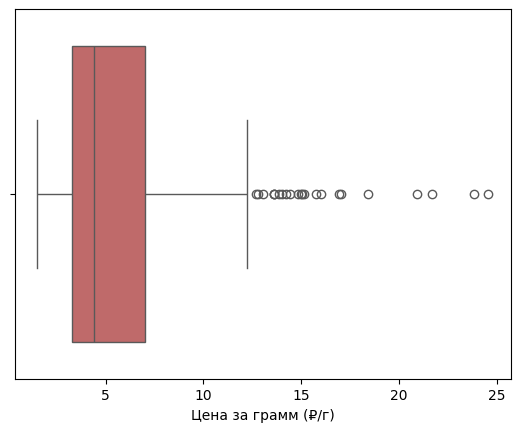

In [ ]:
sns.boxplot(x=df["Цена за грамм (₽/г)"], color='indianred').set_title('')

In [ ]:
Q1 = df["Цена за грамм (₽/г)"].quantile(0.25)
Q3 = df["Цена за грамм (₽/г)"].quantile(0.75)
IQR = Q3 - Q1
upper_fence = Q3 + 1.5 * IQR

df_clean = df[df["Цена за грамм (₽/г)"] <= upper_fence]
print(f'{round(1 - df_clean.shape[0]/df.shape[0], 2)*100}% данных являются выбросами по методу интерквартильного размаха')

10.0% данных являются выбросами по методу интерквартильного размаха


Заметим, что есть выбросы в правом хвосте. При этом их не очень много. Есть смысл построить модель с выбросами и модель без выбросов, чтобы оценить, насколько значимо их влияние.

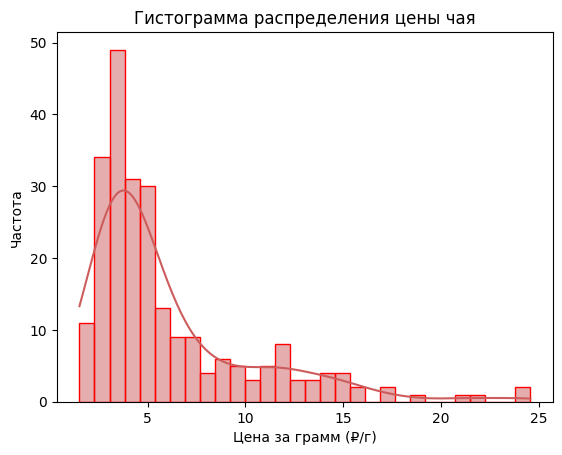

In [ ]:
sns.histplot(df["Цена за грамм (₽/г)"], bins=30, kde=True, color='indianred', edgecolor='red')

plt.xlabel('Цена за грамм (₽/г)')
plt.ylabel('Частота')
plt.title('Гистограмма распределения цены чая')

plt.show()

Заметна асимметрия распределения цены, поэтому возможно потребуется

---

логарифмирование для корректной оценки.

#### Тест Колмогорова-Смирнова на нормальное распределение данных

In [ ]:
from scipy.stats import kstest
stat, p = kstest(df["Цена за грамм (₽/г)"], 'norm', args=(df["Цена за грамм (₽/г)"].mean(), df["Цена за грамм (₽/г)"].std()))
print(f"K-S test: p-value = {p:.4f}")

K-S test: p-value = 0.0000


## Количество ингредиентов

In [ ]:
df['Количество ингредиентов'].value_counts()

,count
Количество ингредиентов,
1,92
2,27
5,23
6,19
7,19
4,19
8,14
9,9
3,7


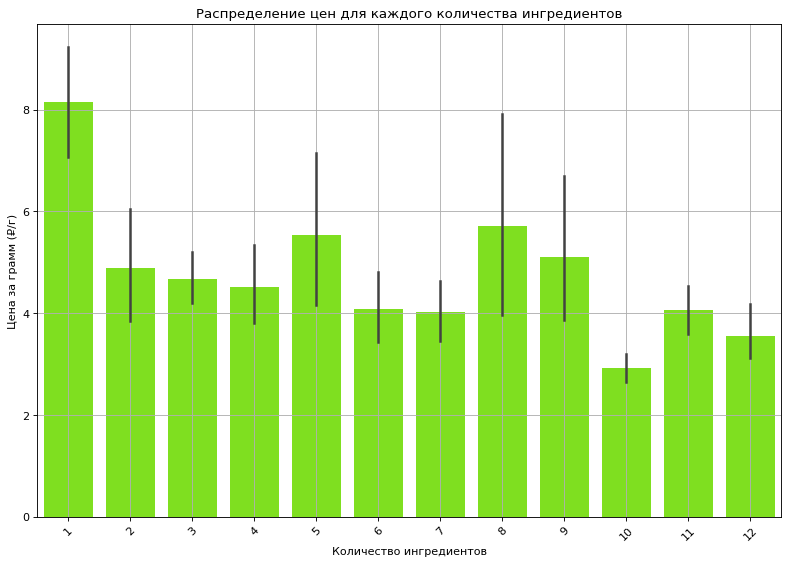

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
sns.barplot(data = df, x = 'Количество ингредиентов', y = 'Цена за грамм (₽/г)', color = 'chartreuse')
plt.xticks(rotation=45)
plt.grid(True)
plt.title('Распределение цен для каждого количества ингредиентов')
plt.show()

По графику не видно существенных различий в цене между чаями с разным количеством ингредиентов. Выделяется только группа с 1 ингредиентом. Средняя цена таких чаев существенно выше общей средней цены по выборке. В дальнейшем можно проверить гипотезу, что мат ожидание чаев с одним ингредиентом равно мат ожиданию чаев с 2+ ингредиентами.

### Проверка гипотезы на равенство математических ожиданий

In [ ]:
group_1 = df[df['Количество ингредиентов'] == 1]['Цена за грамм (₽/г)']
group_2_plus = df[df['Количество ингредиентов'] >= 2]['Цена за грамм (₽/г)']

In [ ]:
# проверка на нормальность
shapiro_1 = stats.shapiro(group_1)
shapiro_2 = stats.shapiro(group_2_plus)

print(f"Группа 1 (p-value): {shapiro_1.pvalue:.3f}")
print(f"Группа 2+ (p-value): {shapiro_2.pvalue:.3f}")

# проверка на равенство дисперсий (тест Левена)
levene_test = stats.levene(group_1, group_2_plus)
print(f"Тест Левена (p-value): {levene_test.pvalue:.3f}")

Группа 1 (p-value): 0.000
Группа 2+ (p-value): 0.000
Тест Левена (p-value): 0.000


In [ ]:
# тест Манна-Уитни
u_stat, p_value = stats.mannwhitneyu(group_1, group_2_plus)
print(f"U-тест: p-value = {p_value:.4f}")

U-тест: p-value = 0.0000


In [ ]:
# Различия значимы, поэтому нулевая гипотеза о равенстве математических ожиданий отвергается

## Страна производитель

In [ ]:
countries = ['Россия', 'Китай', 'Индия', 'Тайвань', 'Шри-Ланка', 'ЮАР']

country_counts = df[countries].sum()

country_shares = country_counts / len(df)
countries_svod = pd.DataFrame({
    'Страна': country_counts.index,
    'Количество чаёв': country_counts.values,
    'Доля в данных (%)': (country_shares * 100).round(2)
})
print(countries_svod)

              Страна  Количество чаёв  Доля в данных (%)
Россия        Россия              135              56.25
Китай          Китай               41              17.08
Индия          Индия                8               3.33
Тайвань      Тайвань                6               2.50
Шри-Ланка  Шри-Ланка                7               2.92
ЮАР              ЮАР                6               2.50


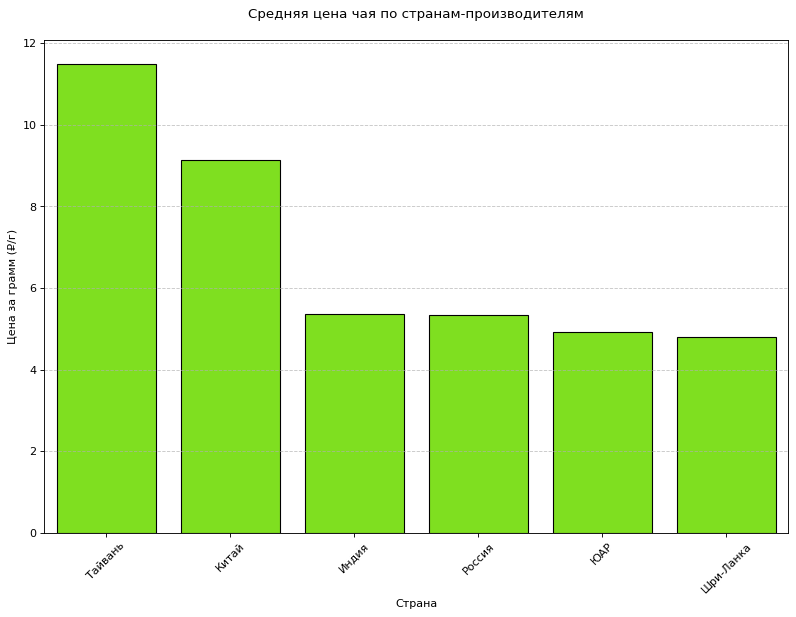

In [ ]:
mean_prices = df[countries].apply(lambda x: df.loc[x == 1, 'Цена за грамм (₽/г)'].mean())

df_plot = pd.DataFrame({
    'Страна': mean_prices.index,
    'Средняя цена (₽/г)': mean_prices.values
}).sort_values('Средняя цена (₽/г)', ascending=False)

plt.figure(figsize=(12, 8), dpi=80)
sns.barplot(
    data=df_plot,
    x='Страна',
    y='Средняя цена (₽/г)',
    color='chartreuse',
    edgecolor='black'
)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.title('Средняя цена чая по странам-производителям', pad=20)
plt.xlabel('Страна')
plt.ylabel('Цена за грамм (₽/г)')
plt.show()

In [ ]:
print(df[df['Тайвань'] == 1]['Цена за грамм (₽/г)'].describe())

count     6.000000
mean     11.500556
std       7.852778
min       3.546667
25%       5.212500
50%      11.535000
75%      13.920000
max      24.566667
Name: Цена за грамм (₽/г), dtype: float64


In [ ]:
print(df[df['Китай'] == 1]['Цена за грамм (₽/г)'].describe())

count    41.000000
mean      9.127713
std       5.996425
min       1.516000
25%       4.090000
50%       7.686667
75%      13.026667
max      23.810000
Name: Цена за грамм (₽/г), dtype: float64


Большинство чаев из выборки произведены в России.

Также заметим, что чай из Тайваня редко встречается, но при этом в большинстве случаев очень дорогой относительно других стран (средняя цена около 11.5 против 6.04 по всей выборке).

Китайский чай встречается чаще, и при этом в среднем тоже существенно дороже чая из остальных стран (средняя цена около 9.44 против 6.04 по всей выборке)

## Купаж

In [ ]:
df['Купаж'].value_counts()

,count
Купаж,
0,146
1,94


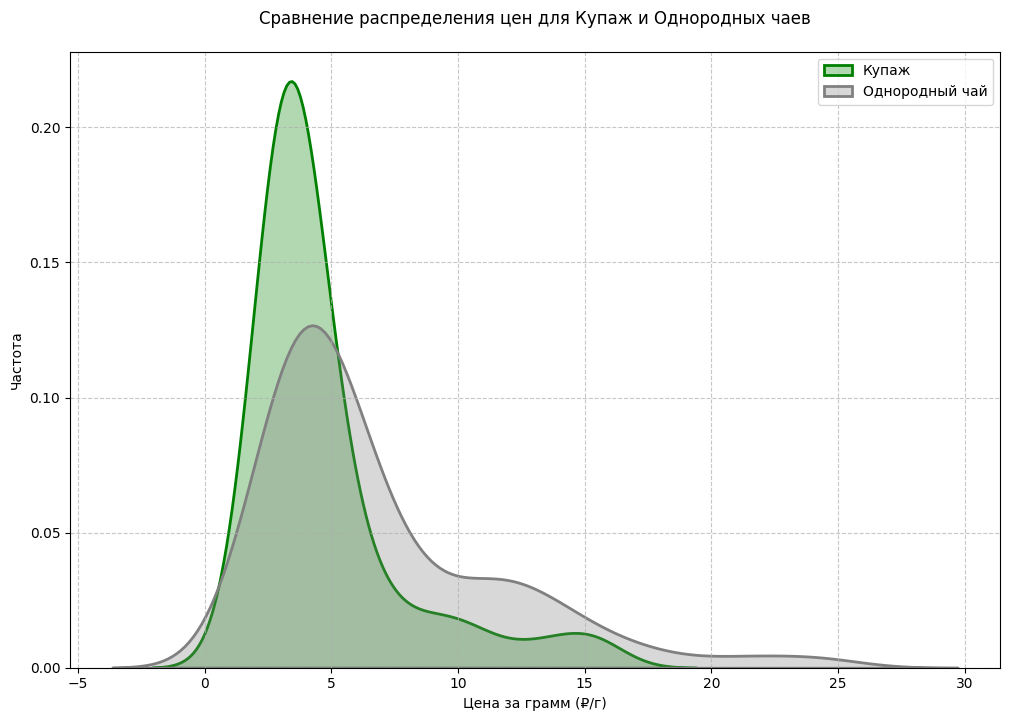

In [ ]:
data_kup = df[df['Купаж'] == 1]['Цена за грамм (₽/г)']
data_no_kup = df[df['Купаж'] == 0]['Цена за грамм (₽/г)']
plt.figure(figsize=(12, 8), dpi=100)
sns.kdeplot(
    data=data_kup,
    color="green",
    label="Купаж",
    linewidth=2,
    fill=True,
    alpha=0.3,
)

sns.kdeplot(
    data=data_no_kup,
    color="grey",
    label="Однородный чай",
    linewidth=2,
    fill=True,
    alpha=0.3,
)

plt.title("Сравнение распределения цен для Купаж и Однородных чаев", pad=20)
plt.xlabel("Цена за грамм (₽/г)")
plt.ylabel("Частота")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

В ~40% случаев чай является смесью (купажом).

Распределение цен для однородных чаев и купажей схоже.

### Тест на равенство распределений

In [ ]:
u_stat, p_value = stats.mannwhitneyu(data_kup, data_no_kup)
print(f"U-тест: p-value = {p_value:.4f}")

U-тест: p-value = 0.0000


## Наличие ароматизатора

In [ ]:
df['Содержит ароматизатор'].value_counts()

,count
Содержит ароматизатор,
1,121
0,119


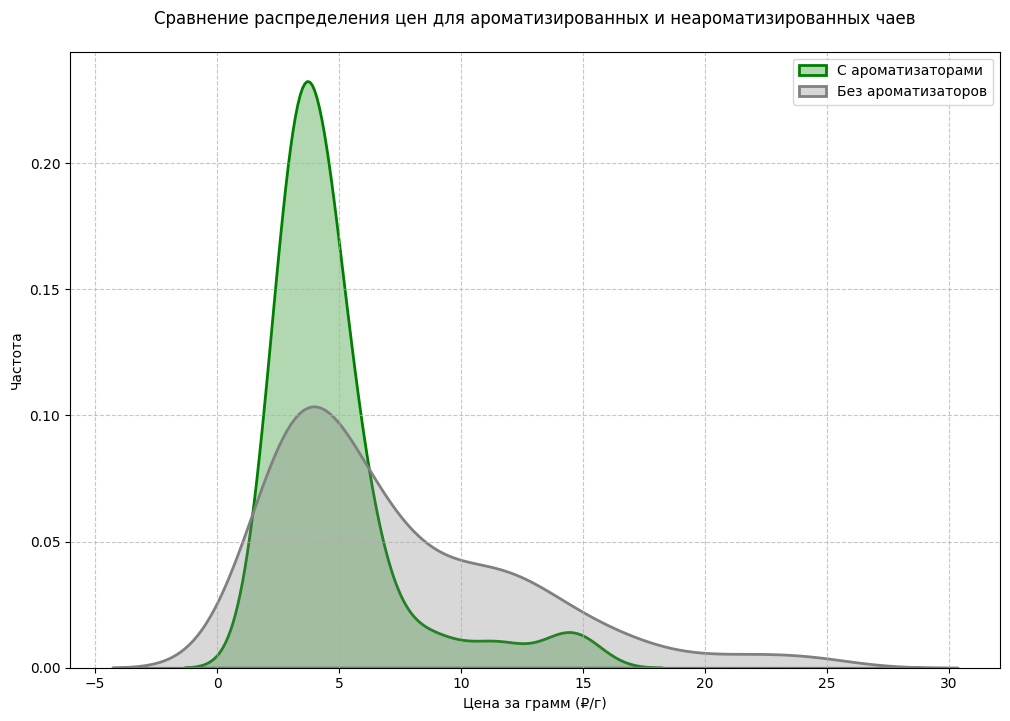

In [ ]:
data_arom = df[df['Содержит ароматизатор'] == 1]['Цена за грамм (₽/г)']
data_no_arom = df[df['Содержит ароматизатор'] == 0]['Цена за грамм (₽/г)']
plt.figure(figsize=(12, 8), dpi=100)
sns.kdeplot(
    data=data_arom,
    color="green",
    label="С ароматизаторами",
    linewidth=2,
    fill=True,
    alpha=0.3,
)

sns.kdeplot(
    data=data_no_arom,
    color="grey",
    label="Без ароматизаторов",
    linewidth=2,
    fill=True,
    alpha=0.3,
)

plt.title("Сравнение распределения цен для ароматизированных и неароматизированных чаев", pad=20)
plt.xlabel("Цена за грамм (₽/г)")
plt.ylabel("Частота")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

По признаку ароматизатора выборка делится примерно в равных пропорциях.

Средние распределений очень близки, при этом распределение цен чаев без ароматизаторов имеет более тяжелые хвосты.

#### Тест на равенство распределений

In [ ]:
u_stat, p_value = stats.mannwhitneyu(data_arom, data_no_arom)
print(f"U-тест: p-value = {p_value:.4f}")

U-тест: p-value = 0.0003


## Непакетированные

In [ ]:
df['Непакетированный'].value_counts()

,count
Непакетированный,
1,185
0,55


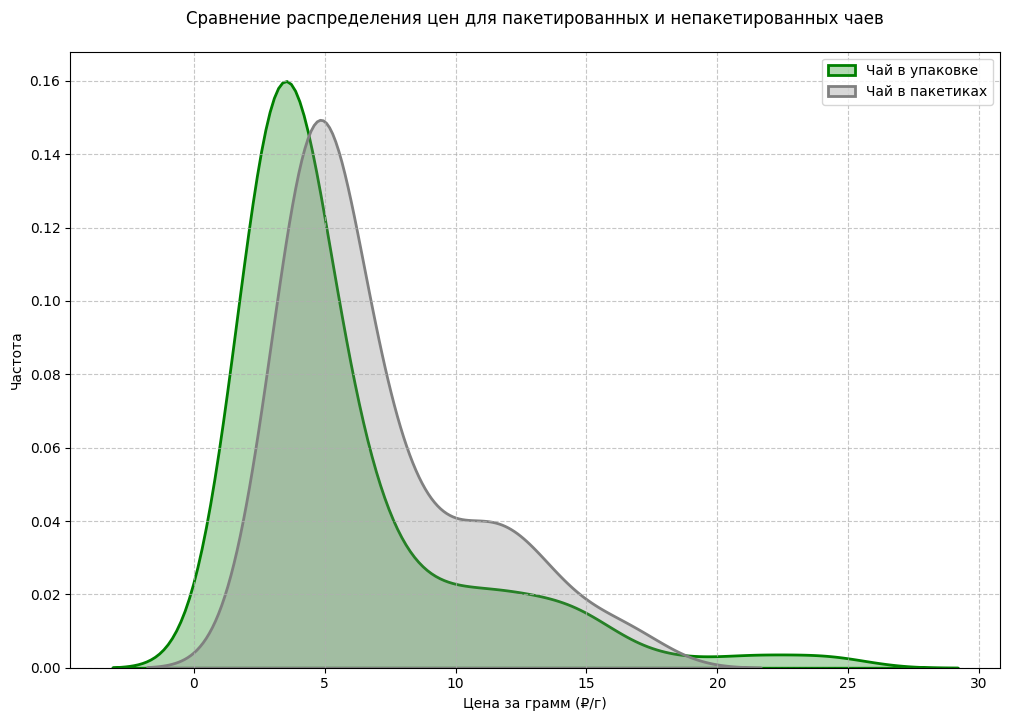

In [ ]:
data_package = df[df['Непакетированный'] == 1]['Цена за грамм (₽/г)']
data_no_package = df[df['Непакетированный'] == 0]['Цена за грамм (₽/г)']
plt.figure(figsize=(12, 8), dpi=100)
sns.kdeplot(
    data=data_package,
    color="green",
    label="Чай в упаковке",
    linewidth=2,
    fill=True,
    alpha=0.3,
)

sns.kdeplot(
    data=data_no_package,
    color="grey",
    label="Чай в пакетиках",
    linewidth=2,
    fill=True,
    alpha=0.3,
)

plt.title("Сравнение распределения цен для пакетированных и непакетированных чаев", pad=20)
plt.xlabel("Цена за грамм (₽/г)")
plt.ylabel("Частота")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

Судя по гистограммам, в среднем чай в пакетиках стоит дороже, так как вид распределений схож, но распределение пакетированных чаев смещено вправо.

## Терпкость

In [ ]:
df['Терпкость'].value_counts()

,count
Терпкость,
1,90
0,55
2,53
3,40
5,2


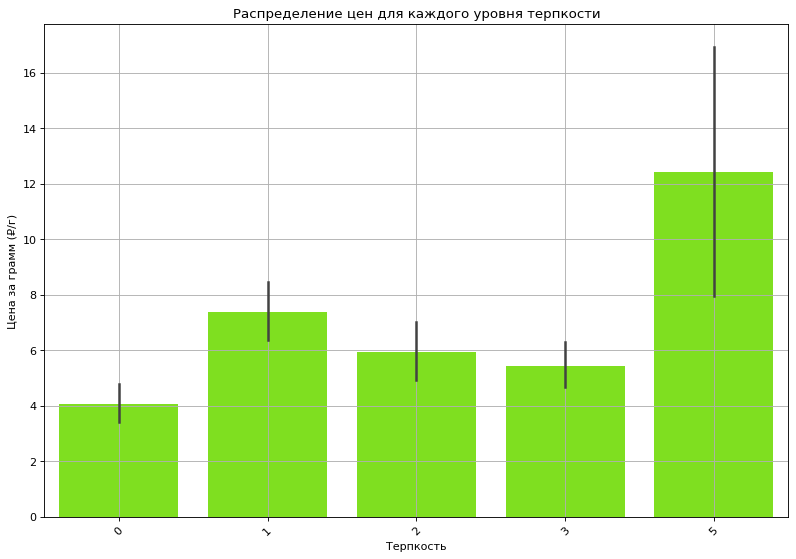

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
sns.barplot(data = df, x = 'Терпкость', y = 'Цена за грамм (₽/г)', color = 'chartreuse')
plt.xticks(rotation=45)
plt.grid(True)
plt.title('Распределение цен для каждого уровня терпкости')
plt.show()

Заметим, что чаи с уровнем терпкости 1 (незначительная терпкость) в среднем существенно дороже. Возможно, это связано с тем, что низкую терпкость предпочитает наибольшее количество людей.



## Кислотность

In [ ]:
df['Кислотность'].value_counts()

,count
Кислотность,
1,163
0,47
2,28
3,2


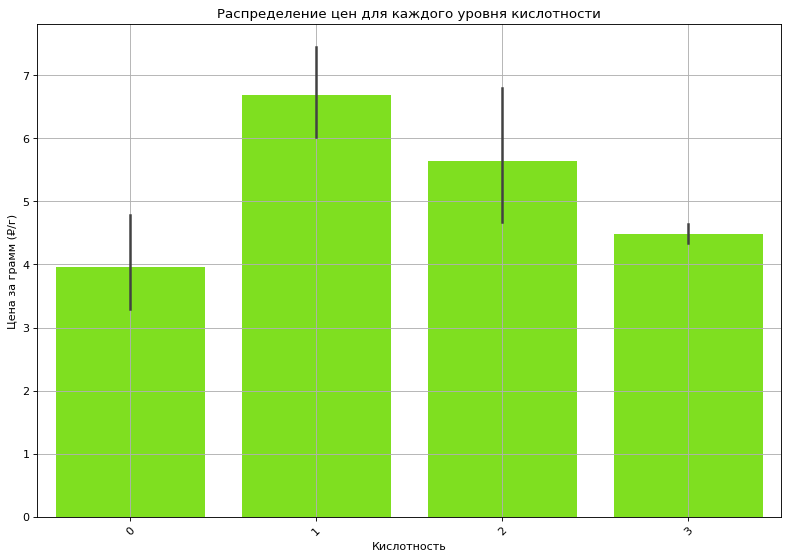

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
sns.barplot(data = df, x = 'Кислотность', y = 'Цена за грамм (₽/г)', color = 'chartreuse')
plt.xticks(rotation=45)
plt.grid(True)
plt.title('Распределение цен для каждого уровня кислотности')
plt.show()

По признаку кислотности наблюдается схожая картина. Наибольшая средняя цена у чаев с умеренной кислотность. При этом таких чаев больше всего в выборке. Это может быть связано с тем что умеренную кислотность предпочитает большинство людей, следовательно производители, максимизирующие продажи, концентрируются на произаодстве таких чаёв.

## Интенсивность послевкусия

In [ ]:
df['Интенсивность послевкусия'].value_counts()

,count
Интенсивность послевкусия,
2,152
0,50
4,16
5,7
3,7
6,6
1,2


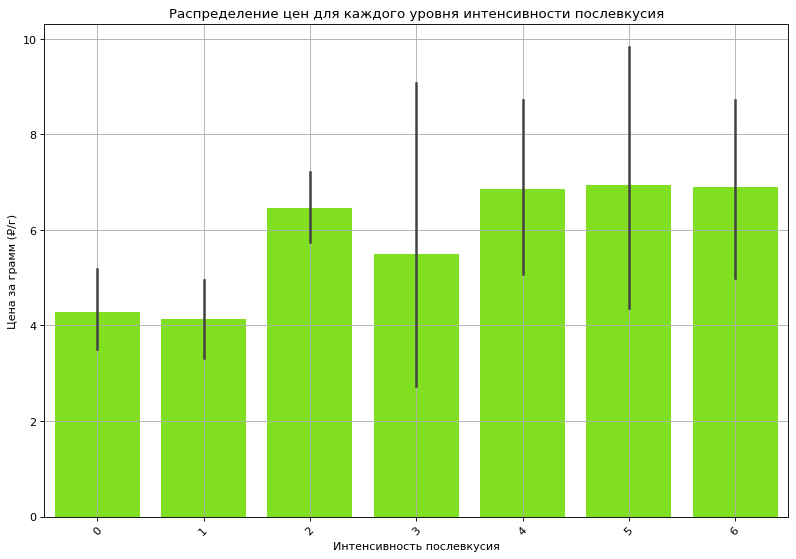

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
sns.barplot(data = df, x = 'Интенсивность послевкусия', y = 'Цена за грамм (₽/г)', color = 'chartreuse')
plt.xticks(rotation=45)
plt.grid(True)
plt.title('Распределение цен для каждого уровня интенсивности послевкусия')
plt.show()

Если рассматривать чаи с интенсивностью послевкусия 0 и 1 и чаи с интенсивностью послевкусия 2, 3, 4, 5 и 6 как отдельные группы, то можно предположить, что у первой группы цена за грамм меньше.

### Тест на равенство распределений цен с интенсивностью послевкусия 0, 1 и 2, 3, 4, 5, 6

In [ ]:
data_intens = df[df['Интенсивность послевкусия'].isin([2,3,4,5,6])]['Цена за грамм (₽/г)']
data_no_intens = df[df['Интенсивность послевкусия'].isin([0,1])]['Цена за грамм (₽/г)']

In [ ]:
u_stat, p_value = stats.mannwhitneyu(data_intens, data_no_intens)
print(f"U-тест: p-value = {p_value:.4f}")

U-тест: p-value = 0.0000


## Горечь

In [ ]:
df['Горечь'].value_counts()

,count
Горечь,
0,216
1,24


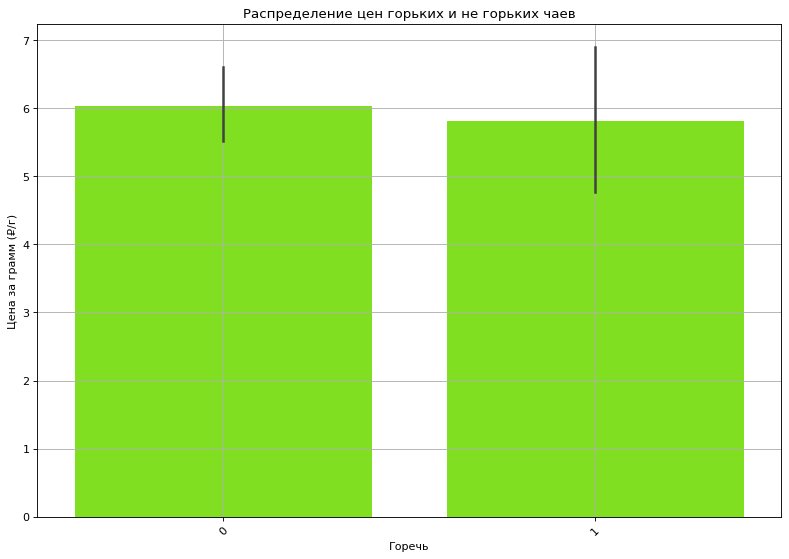

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
sns.barplot(data = df, x = 'Горечь', y = 'Цена за грамм (₽/г)', color = 'chartreuse')
plt.xticks(rotation=45)
plt.grid(True)
plt.title('Распределение цен горьких и не горьких чаев')
plt.show()

Очень редко производитель заранее отмечает чай, как горький. Интуитивно, факт наличия горечи должен отрицательно влиять на цену. В нашей выборке если и есть влияние горечи, то оно незначительно.

## Сладость

In [ ]:
df['Сладкость'].value_counts()

,count
Сладкость,
0,201
1,39


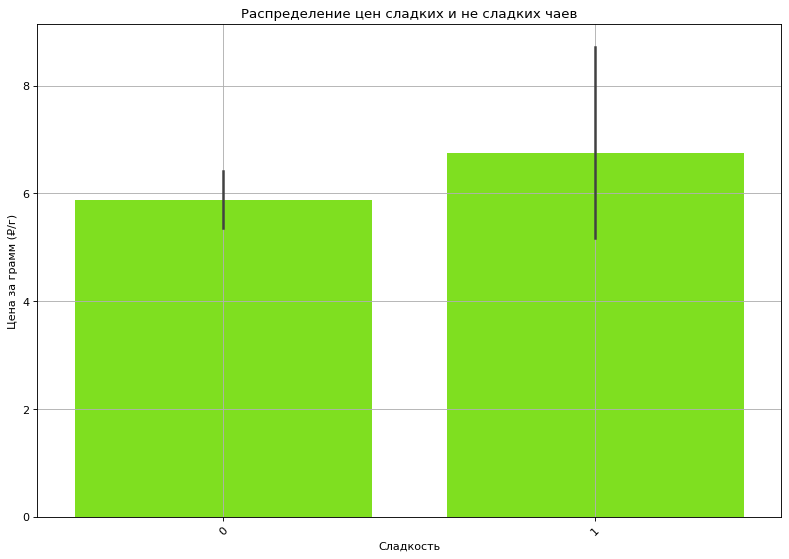

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
sns.barplot(data = df, x = 'Сладкость', y = 'Цена за грамм (₽/г)', color = 'chartreuse')
plt.xticks(rotation=45)
plt.grid(True)
plt.title('Распределение цен сладких и не сладких чаев')
plt.show()

В среднем сладкие чаи чуть дороже.

# Функции

In [ ]:
# Вызов ols
def get_model_summary(y, X):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model.summary()

In [ ]:
# Тест на адекватность
def r2(X, y):
  model = sm.OLS(y, X).fit()

  f_stat = model.fvalue
  p_value = model.f_pvalue

  print(f"F-statistic: {f_stat:.2f}")
  print(f"p-value: {p_value:.4f}")

  if p_value < 0.05:
      print("Гипотеза H0 об адекватности модели отвергается. Модель адекватна.")
  else:
      print("Гипотеза H0 не отвергается. Модель неадекватна.")

In [ ]:
# Отбор переменных в регрессии по AIC
def backward_elimination_aic(X, y, verbose=True):
    included = list(X.columns)
    current_aic = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit().aic
    while True:
        aic_candidates = []
        for column in included:
            # You need to call .fit() on the model before accessing .aic
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included].drop(column, axis=1)))).fit()
            aic_candidates.append((column, model.aic))
        best_feature, best_aic = min(aic_candidates, key=lambda x: x[1])
        if best_aic < current_aic:
            included.remove(best_feature)
            current_aic = best_aic
            if verbose:
                print(f'Удаляем {best_feature} (AIC={best_aic:.2f})')
        else:
            break
    return included

In [ ]:
#Бокс-Кокс - функциональная форма
def geometric_mean(y):
    return np.exp(np.mean(np.log(y)))

def compare_linear_log_models(Y, X1, X2, alpha=0.05):
    gY = geometric_mean(Y)
    Y_star = Y / gY

    # Линейная модель
    model = sm.OLS(Y_star, X1).fit()
    RSS = np.sum(model.resid ** 2)

    # Полулогарифмическая модель/логарифмическая
    ln_Y_star = np.log(Y_star)
    model2 = sm.OLS(ln_Y_star, X2).fit()
    RSS2 = np.sum(model2.resid ** 2)

    n = len(Y)
    chi2_stat = n / 2 * np.log(RSS / RSS2)
    chi2_critical = chi2.ppf(1 - alpha, df=1)

    print("Среднее геометрическое Y:", gY)
    print("RSS (линейная модель):", RSS)
    print("RSS2:", RSS2)
    print("Статистика хи-квадрат:", chi2_stat)
    print("Критическое значение хи-квадрат (0.05):", chi2_critical)

    if chi2_stat > chi2_critical:
      print("Гипотеза H0 отвергается: есть значимые различия между моделями.")
      if RSS < RSS2:
        print("Линейная модель лучше")
      else: print("Модель с лог преобразованием лучше")
    else:
      print("Гипотеза H0 не отвергается: различий между моделями нет.")
    return RSS2

In [ ]:
#Без / с выбросами
def robust_regression(X, y, threshold=1.5):
    print("С выбросами:")
    model = sm.OLS(y, X).fit()
    print(model.summary())

    df = X.copy()
    df['target'] = y

    Q1 = df['target'].quantile(0.25)
    Q3 = df['target'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    mask = (df['target'] >= lower_bound) & (df['target'] <= upper_bound)
    clean_data = df[mask].copy()

    y_clean = clean_data['target']
    X_clean = clean_data.drop('target', axis=1)
    X_clean = sm.add_constant(X_clean)

    print("Без выбросами:")
    model = sm.OLS(y_clean, X_clean).fit()
    print(model.summary())

    return model, clean_data

In [ ]:
# Две модели или одна
def two_mod(mod1, mod2, X, y, X1, y1, X2, y2, a):
  model_pooled = sm.OLS(y, X).fit()
  model1 = sm.OLS(y1, X1).fit()
  model2 = sm.OLS(y2, X2).fit()

  SSR_pooled = model_pooled.ssr
  SSR1 = model1.ssr
  SSR2 = model2.ssr

  k = len(model_pooled.params)
  n1 = len(mod1)
  n2 = len(mod2)

  chow_stat = ((SSR_pooled - (SSR1 + SSR2)) / (k)) / ((SSR1 + SSR2) / (n1 + n2 - 2 * k))

  p_value = 1 - stats.f.cdf(chow_stat, k, n1 + n2 - 2 * k)

  print(f"RSS(полная модель): {SSR_pooled}")
  print(f"RSS(ограниченная модель): {SSR1 + SSR2}")
  print(f"RSS(модели для мужчин): {SSR1}")
  print(f"RSS(модели для женщин): {SSR2}")
  print(f"F-статистика: {chow_stat}")
  print(f"p-value: {p_value}")
  if p_value > a:
    print("H0 не отвергается: модели одинаковы")
  else:
    print("H0 отвергается: модели разные")

In [ ]:
# гетероскедастичность
def check_heteroscedasticity_white(X, y, alpha):
  model = sm.OLS(y, X).fit()
  white_test = sms.het_white(model.resid, model.model.exog)
  p_value = white_test[3]

  if p_value < alpha:
    print(f'Есть гетероскедастичности согласно тесту Уайта (p < {alpha})')
  else:
    print(f'Нет гетероскедастичности согласно тесту Уайта (p > {alpha})')


def check_heteroscedasticity_glazer(X, y, alpha):
  model = sm.OLS(y, X).fit()
  residuals = model.resid
  abs_residuals = np.abs(residuals)

  X_sqrt = np.sqrt(X.drop('const', axis=1)) if 'const' in X.columns else np.sqrt(X)
  X1 =  sm.add_constant(X_sqrt)
  glazer_model1 = sm.OLS(abs_residuals, X1).fit()

  X_inv = 1 / X.drop('const', axis=1).replace(0, 1e-6) if 'const' in X.columns else 1 / X.replace(0, 1e-6)
  X2 = add_constant(X_inv)
  glazer_model2 = sm.OLS(abs_residuals, X2).fit()

  X3 = X.copy()
  glazer_model3 = sm.OLS(abs_residuals, X3).fit()

  if (glazer_model1.pvalues[1:] < alpha).any() or (glazer_model2.pvalues[1:] < alpha).any() or (glazer_model3.pvalues[1:] < alpha).any():
      print(f'Есть гетероскедастичность согласно тесту Глейзера (p < {alpha})')
  else:
      print(f'Гетероскедастичность отсутствует согласно тесту Глейзера (p > {alpha})')


def check_heteroscedasticity_graph(X, y):
  model = sm.OLS(y, X).fit()
  plt.scatter(model.predict(X), model.resid)
  plt.xlabel('Прогнозы')
  plt.ylabel('Остатки')
  plt.axhline(y=0, color='red', linestyle='--')
  plt.title('График «остатки—прогнозы»')
  plt.show()

def check_heteroscedasticity_bp(X, alpha, resids):
  bp_test = het_breuschpagan(resids, X)
  p_value = bp_test[1]

  if p_value < alpha:
    print(f'Есть гетероскедастичности согласно Бройша-Пагана (p < {alpha})')
  else:
    print(f'Нет гетероскедастичности согласно Бройша-Пагана (p > {alpha})')


def check_heteroscedasticity(X, y, alpha, resids):
  check_heteroscedasticity_graph(X, y)
  check_heteroscedasticity_white(X, y, alpha)
  check_heteroscedasticity_glazer(X, y, alpha)
  check_heteroscedasticity_bp(X, alpha, resids)

In [ ]:
# мультиколлинеарность
def check_multicollinearity_heat_map(X):
    corr = X[[col for col in X if col != 'const']].corr()

    plt.figure(figsize=(12, 10))

    sns.heatmap(corr,
                annot=True,
                cmap='coolwarm',
                fmt='.2f',
                linewidths=0.5,
                annot_kws={'size': 10})

    plt.title('Матрица корреляций', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

def check_multicollinearity_vif(X):
  X_no_const = X[[col for col in X if col != 'const']]

  vif = pd.DataFrame()
  vif['VIF'] = [variance_inflation_factor(X_no_const.values, i) for i in range(X_no_const.shape[1])]
  vif['Feature'] = X_no_const.columns

  vif_features = []

  for idx, row in vif.iterrows():
    if row['VIF'] >= 10:
      vif_features.append(row['Feature'])

  print(vif)

  if vif_features:
    print(f'Есть признаки с большим VIF, возможна мультиколлинеарность: {vif_features}')
  else:
    print(f'Нет признаков с большим VIF')

def check_multicollinearity(X):
  check_multicollinearity_heat_map(X)
  check_multicollinearity_vif(X)

In [ ]:
def bootstrap_ols(X, y, n_boot=1000):
    coefs = []
    n = len(X)

    for _ in range(n_boot):
        # Генерация бутстрап-выборки
        idx = np.random.choice(n, n, replace=True)
        X_boot = X.iloc[idx]
        y_boot = y.iloc[idx]

        # Обучение модели
        model = sm.OLS(y_boot, X_boot).fit()
        coefs.append(model.params)

    coefs_df = pd.DataFrame(coefs, columns=X.columns)
    return coefs_df.quantile([0.025, 0.975])

In [ ]:
def test_coefficient_equality(models_mq, bootstrap_coefs, variable, q1_idx, q2_idx, alpha=0.05):

    coef_q1 = models_mq[q1_idx].params[variable]
    coef_q2 = models_mq[q2_idx].params[variable]

    q1 = list(bootstrap_coefs.keys())[q1_idx]
    q2 = list(bootstrap_coefs.keys())[q2_idx]

    se_q1 = pd.DataFrame(bootstrap_coefs[q1]).std()[variable]
    se_q2 = pd.DataFrame(bootstrap_coefs[q2]).std()[variable]

    diff = coef_q1 - coef_q2
    se_diff = np.sqrt(se_q1**2 + se_q2**2)

    wald_stat = diff / se_diff
    p_value = 2 * (1 - stats.norm.cdf(abs(wald_stat)))

    result = {
        'variable': variable,
        'q1': q1,
        'q2': q2,
        'coef_q1': coef_q1,
        'coef_q2': coef_q2,
        'se_q1': se_q1,
        'se_q2': se_q2,
        'difference': diff,
        'se_difference': se_diff,
        'wald_statistic': wald_stat,
        'p_value': p_value,
        'alpha': alpha,
        'reject_null': p_value < alpha
    }

    print(f"\nТест равенства коэффициентов для '{variable}' между квантилями {q1} и {q2}:")
    print(f"Коэффициент для q={q1}: {coef_q1:.4f} (SE: {se_q1:.4f})")
    print(f"Коэффициент для q={q2}: {coef_q2:.4f} (SE: {se_q2:.4f})")
    print(f"Разность: {diff:.4f} (SE разности: {se_diff:.4f})")
    print(f"Wald statistic: {wald_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < alpha:
        print(f"\nВывод: Отвергаем H0 (p={p_value:.4f} < {alpha}) - коэффициенты значимо различаются.")
        print(f"Это означает, что влияние переменной '{variable}' разное для квантилей {q1} и {q2}.")
    else:
        print(f"\nВывод: Не отвергаем H0 (p={p_value:.4f} >= {alpha}) - нет доказательств различий.")
        print(f"Эффект переменной '{variable}' одинаков для квантилей {q1} и {q2}.")

    return result

In [ ]:
def paired_bootstrap_ols(X, y, n_bootstrap=1000, ci_width=0.95):

    # Оригинальная модель
    model = sm.OLS(y, X).fit()
    original_coefs = model.params

    # Бутстрап
    n = len(y)
    bootstrap_coefs = np.zeros((n_bootstrap, len(original_coefs)))

    for i in tqdm(range(n_bootstrap), desc="Бутстрап"):
        # Выборка с замещением (индексы от 0 до n-1)
        idx = np.random.choice(n, n, replace=True)
        X_sample = X.iloc[idx] if hasattr(X, 'iloc') else X[idx]
        y_sample = y.iloc[idx] if hasattr(y, 'iloc') else y[idx]

        # Оцениваем модель
        model_boot = sm.OLS(y_sample, X_sample).fit()
        bootstrap_coefs[i] = model_boot.params

    # Рассчитываем ДИ
    alpha = (1 - ci_width) / 2
    ci_lower = np.percentile(bootstrap_coefs, 100 * alpha, axis=0)
    ci_upper = np.percentile(bootstrap_coefs, 100 * (1 - alpha), axis=0)

    # Собираем результаты в таблицу
    results = pd.DataFrame({
        'coef': original_coefs,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }, index=model.params.index)  # Используем названия коэффициентов


    return results

In [ ]:
def collect_bootstrap_residuals(X, y, n_bootstrap=1000):
    residuals = []
    n = len(y)
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        X_boot = X.iloc[idx] if hasattr(X, 'iloc') else X[idx]
        y_boot = y.iloc[idx] if hasattr(y, 'iloc') else y[idx]
        model_boot = sm.OLS(y_boot, X_boot).fit()
        residuals.extend(model_boot.resid)
    return np.array(residuals)

# Работа с моделью

## Модель с отобранными по AIC переменными

In [ ]:
X_all = df.drop(['Цена за грамм (₽/г)', 'Название'], axis=1)
X_all = add_constant(X_all)
y_all = df['Цена за грамм (₽/г)']
y_log_all = np.log(y_all)

In [ ]:
# Функциональная форма: линейная или полулог
compare_linear_log_models(y_all, X_all, X_all, alpha=0.05)

Среднее геометрическое Y: 4.99123111553876
RSS (линейная модель): 117.12619503211604
RSS2: 54.125112221269696
Статистика хи-квадрат: 92.63444206354309
Критическое значение хи-квадрат (0.05): 3.841458820694124
Гипотеза H0 отвергается: есть значимые различия между моделями.
Модель с лог преобразованием лучше


54.125112221269696

In [ ]:
# Отбор переменных в регрессии по AIC - линейная модель
selected_features_aic = backward_elimination_aic(X_all, y_log_all)
print("Отобранные переменные по AIC:", selected_features_aic)

Удаляем Сладкость (AIC=363.65)
Удаляем Терпкость (AIC=361.65)
Удаляем Шри-Ланка (AIC=359.68)
Удаляем ЮАР (AIC=357.78)
Удаляем Кислотность (AIC=355.96)
Удаляем Индия (AIC=354.24)
Удаляем Горечь (AIC=352.60)
Удаляем Интенсивность послевкусия (AIC=351.49)
Удаляем Неинтенсивный (AIC=350.50)
Удаляем Количество ингредиентов (AIC=350.17)
Удаляем Купаж (AIC=349.36)
Отобранные переменные по AIC: ['const', 'Россия', 'Китай', 'Тайвань', 'Содержит ароматизатор', 'Непакетированный', 'Прозрачный', 'Непрозрачный', 'Интенсивный', 'Продолжительное послевкусие']


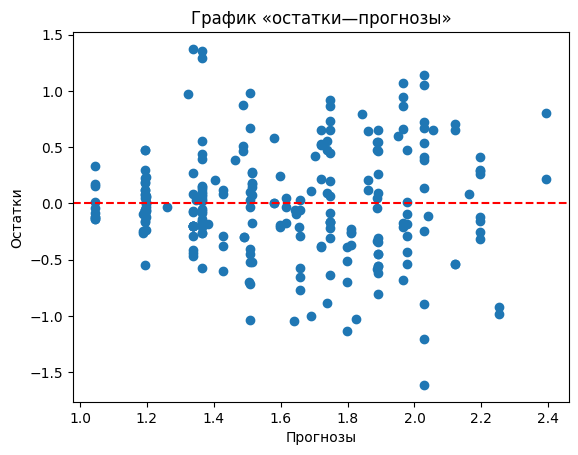

Есть гетероскедастичности согласно тесту Уайта (p < 0.05)
Есть гетероскедастичность согласно тесту Глейзера (p < 0.05)
Есть гетероскедастичности согласно Бройша-Пагана (p < 0.05)


In [ ]:
# Гетероскедастичность
X_aic = X_all[selected_features_aic]
model_aic = sm.OLS(y_log_all, X_aic).fit(cov_type='HC3')

resids_aic = model_aic.resid
check_heteroscedasticity(X_aic, y_log_all, 0.05, resids_aic)

In [ ]:
print(model_aic.summary())

                             OLS Regression Results                            
Dep. Variable:     Цена за грамм (₽/г)   R-squared:                       0.312
Model:                             OLS   Adj. R-squared:                  0.285
Method:                  Least Squares   F-statistic:                     14.17
Date:                 Wed, 07 May 2025   Prob (F-statistic):           4.03e-18
Time:                         11:23:14   Log-Likelihood:                -164.68
No. Observations:                  240   AIC:                             349.4
Df Residuals:                      230   BIC:                             384.2
Df Model:                            9                                         
Covariance Type:                   HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const   

## Итоговая модель

In [ ]:
X = df[['Количество ингредиентов', 'Россия', 'Китай', 'Тайвань', 'Купаж', 'Содержит ароматизатор', 'Непакетированный', 'Прозрачный', 'Непрозрачный', 'Интенсивный', 'Продолжительное послевкусие']]
X = add_constant(X)
y = df['Цена за грамм (₽/г)']
log_y = np.log(y)

In [ ]:
# Тест на адекватность
r2(X, log_y)

F-statistic: 9.77
p-value: 0.0000
Гипотеза H0 об адекватности модели отвергается. Модель адекватна.


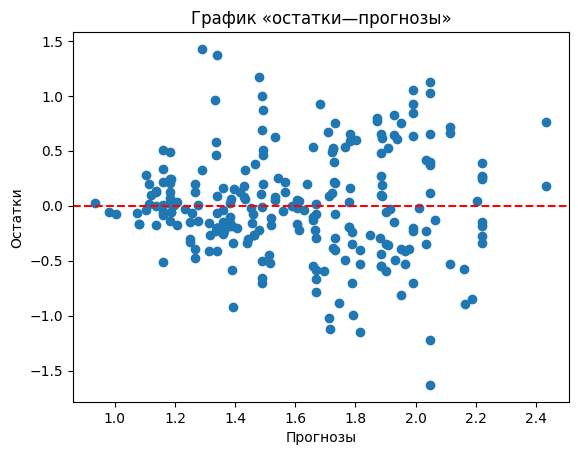

Есть гетероскедастичности согласно тесту Уайта (p < 0.05)
Есть гетероскедастичность согласно тесту Глейзера (p < 0.05)
Есть гетероскедастичности согласно Бройша-Пагана (p < 0.05)


In [ ]:
# Гетероскедастичность
model = sm.OLS(log_y, X).fit(cov_type='HC3')

resids = model.resid
check_heteroscedasticity(X, log_y, 0.05, resids)

In [ ]:
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Цена за грамм (₽/г)   R-squared:                       0.320
Model:                             OLS   Adj. R-squared:                  0.288
Method:                  Least Squares   F-statistic:                     11.89
Date:                 Wed, 07 May 2025   Prob (F-statistic):           1.56e-17
Time:                         11:23:14   Log-Likelihood:                -163.25
No. Observations:                  240   AIC:                             350.5
Df Residuals:                      228   BIC:                             392.3
Df Model:                           11                                         
Covariance Type:                   HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const   

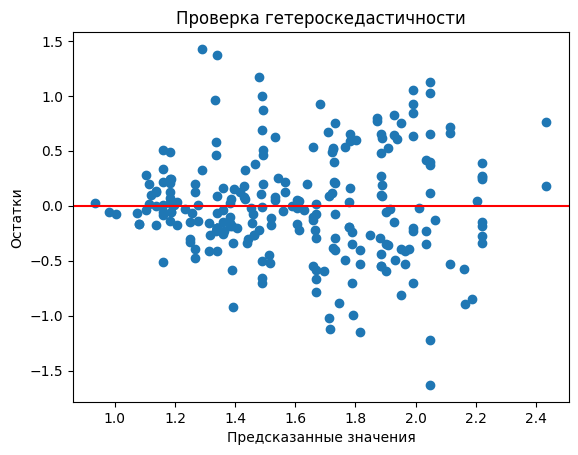

In [ ]:
# график остатки-прогнозы для модели с cov_type='HC3'
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Проверка гетероскедастичности')
plt.show()

## Сравнение исходной модели и модели с робастными стандартными ошибками

In [ ]:
# model - модель с cov_type=HC3
model_start = sm.OLS(log_y, X).fit()

In [ ]:
stderr_classic = model_start.bse
stderr_hc3 = model.bse

# Таблица сравнения
comparison = pd.DataFrame({
    'Стандартные ошибки исходной модели': stderr_classic,
    'Стандартные ошибки HC3 модели': stderr_hc3,
    'Разница в %': (stderr_hc3 - stderr_classic) / stderr_classic * 100
})

In [ ]:
comparison

,Стандартные ошибки исходной модели,Стандартные ошибки HC3 модели,Разница в %
const,0.127676,0.115783,-9.314512
Количество ингредиентов,0.018477,0.016053,-13.116197
Россия,0.099629,0.089033,-10.634858
Китай,0.112109,0.136181,21.471865
Тайвань,0.216445,0.348366,60.948796
Купаж,0.081616,0.088551,8.497215
Содержит ароматизатор,0.088672,0.078340,-11.652081
Непакетированный,0.094834,0.090069,-5.024443
Прозрачный,0.120354,0.121584,1.022377
Непрозрачный,0.161002,0.186643,15.925886


В модели с HC3 стандартные ошибки для регрессоров "Китай" и "Тайвань" серьезно выросли в сравнении с исходной моделью (на 21 и 60% соответственно), что говорит о локальной гетероскедастичности. Причем регрессоры "Россия" и "Содержит ароматизатор" оказались значимы в модели c HC3, что подтверждает устойчивость результатов модели с HC3.

## Дальнейшая работа с моделью

In [ ]:
# Уберем незначимые признаки
X_significant = X.drop(['Количество ингредиентов', 'Тайвань', 'Купаж', 'Непрозрачный'], axis=1)
model_significant = sm.OLS(log_y, X_significant).fit(cov_type='HC3')
print(model_significant.summary())

                             OLS Regression Results                            
Dep. Variable:     Цена за грамм (₽/г)   R-squared:                       0.285
Model:                             OLS   Adj. R-squared:                  0.263
Method:                  Least Squares   F-statistic:                     15.50
Date:                 Wed, 07 May 2025   Prob (F-statistic):           1.27e-16
Time:                         11:23:15   Log-Likelihood:                -169.35
No. Observations:                  240   AIC:                             354.7
Df Residuals:                      232   BIC:                             382.5
Df Model:                            7                                         
Covariance Type:                   HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const   

In [ ]:
# Без/с выбросами
robust_regression(X, log_y, threshold=1.5)

С выбросами:
                             OLS Regression Results                            
Dep. Variable:     Цена за грамм (₽/г)   R-squared:                       0.320
Model:                             OLS   Adj. R-squared:                  0.288
Method:                  Least Squares   F-statistic:                     9.771
Date:                 Wed, 07 May 2025   Prob (F-statistic):           1.88e-14
Time:                         11:23:15   Log-Likelihood:                -163.25
No. Observations:                  240   AIC:                             350.5
Df Residuals:                      228   BIC:                             392.3
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x78a2dfc24150>,
      const  Количество ингредиентов  Россия  Китай  Тайвань  Купаж  \
 0      1.0                        3       1      0        0      1   
 1      1.0                        8       1      0        0      1   
 2      1.0                        1       0      1        0      1   
 3      1.0                        1       0      0        0      0   
 4      1.0                        1       0      0        0      0   
 ..     ...                      ...     ...    ...      ...    ...   
 235    1.0                        4       1      0        0      0   
 236    1.0                        7       1      0        0      0   
 237    1.0                        1       1      0        0      0   
 238    1.0                        5       1      0        0      0   
 239    1.0                        4       1      0        0      1   
 
      Содержит ароматизатор  Непакетированный  Прозрачный  Непр

In [ ]:
# Пакетированные или непакетированные
datapack = df[df['Непакетированный'] == 0]
datanopack = df[df['Непакетированный'] == 1]

X_pack = datapack[['Количество ингредиентов', 'Россия', 'Китай', 'Тайвань', 'Купаж', 'Содержит ароматизатор', 'Прозрачный', 'Непрозрачный', 'Интенсивный', 'Продолжительное послевкусие']]
X_pack = add_constant(X_pack)
y_pack = datapack['Цена за грамм (₽/г)']
y_pack_log = np.log(y_pack)

X_nopack = datanopack[['Количество ингредиентов', 'Россия', 'Китай', 'Тайвань', 'Купаж', 'Содержит ароматизатор', 'Прозрачный', 'Непрозрачный', 'Интенсивный', 'Продолжительное послевкусие']]
X_nopack = add_constant(X_nopack)
y_nopack = datanopack['Цена за грамм (₽/г)']
y_nopack_log = np.log(y_nopack)

two_mod(datapack, datanopack, X, log_y, X_pack, y_pack_log, X_nopack, y_nopack_log, 0.05)

RSS(полная модель): 54.77214099165724
RSS(ограниченная модель): 54.295486026912926
RSS(модели для мужчин): 10.433377625006017
RSS(модели для женщин): 43.86210840190691
F-статистика: 0.15802030690258195
p-value: 0.999503966253635
H0 не отвергается: модели одинаковы


In [ ]:
# У России - особый путь
norus = df[df['Россия'] == 0]
rus = df[df['Россия'] == 1]

X_norus = norus[['Количество ингредиентов', 'Китай', 'Тайвань', 'Купаж', 'Содержит ароматизатор', 'Непакетированный', 'Прозрачный', 'Непрозрачный', 'Интенсивный', 'Продолжительное послевкусие']]
X_norus = add_constant(X_norus)
y_norus = np.log(norus['Цена за грамм (₽/г)'])
y_norus_log = np.log(y_norus)

X_rus = rus[['Количество ингредиентов', 'Китай', 'Тайвань', 'Купаж', 'Содержит ароматизатор', 'Непакетированный', 'Прозрачный', 'Непрозрачный', 'Интенсивный', 'Продолжительное послевкусие']]
X_rus = add_constant(X_rus)
y_rus = np.log(rus['Цена за грамм (₽/г)'])
y_rus_log = np.log(y_rus)

two_mod(norus, rus, X, log_y, X_norus, y_norus_log, X_rus, y_rus_log, 0.05)

RSS(полная модель): 54.77214099165724
RSS(ограниченная модель): 22.083748824662905
RSS(модели для мужчин): 13.392077770532204
RSS(модели для женщин): 8.691671054130701
F-статистика: 26.64362213487906
p-value: 1.1102230246251565e-16
H0 отвергается: модели разные


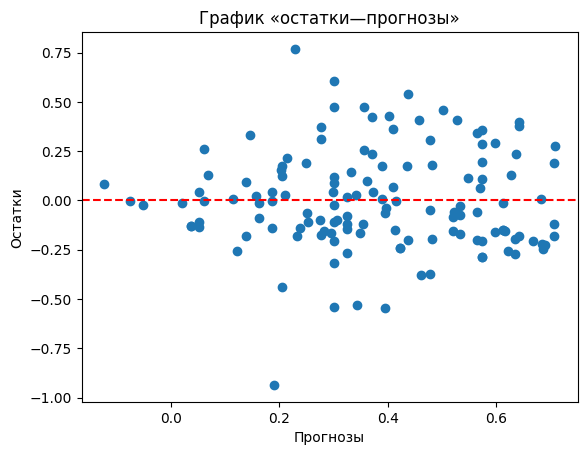

Нет гетероскедастичности согласно тесту Уайта (p > 0.05)
Есть гетероскедастичность согласно тесту Глейзера (p < 0.05)
Есть гетероскедастичности согласно Бройша-Пагана (p < 0.05)


In [ ]:
# Гетероскедастичность
model_rus = sm.OLS(y_rus_log, X_rus).fit(cov_type='HC3')

resids_rus = model_rus.resid
check_heteroscedasticity(X_rus, y_rus_log, 0.05, resids_rus)

In [ ]:
print(model_rus.summary())

                             OLS Regression Results                            
Dep. Variable:     Цена за грамм (₽/г)   R-squared:                       0.369
Model:                             OLS   Adj. R-squared:                  0.329
Method:                  Least Squares   F-statistic:                     18.92
Date:                 Wed, 07 May 2025   Prob (F-statistic):           2.00e-18
Time:                         11:23:15   Log-Likelihood:                -6.4103
No. Observations:                  135   AIC:                             30.82
Df Residuals:                      126   BIC:                             56.97
Df Model:                            8                                         
Covariance Type:                   HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const   

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 8
  warnings.warn('covariance of constraints does not have full '


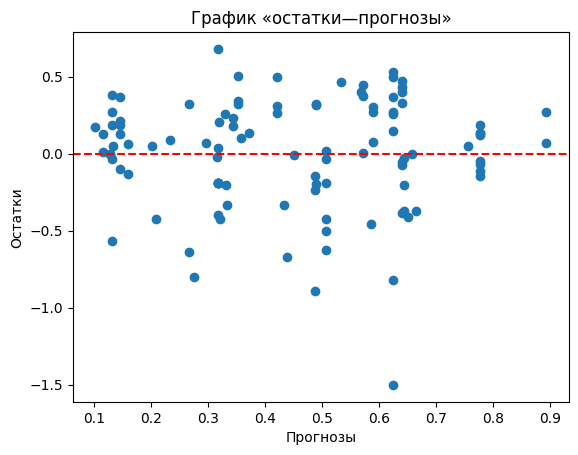

Нет гетероскедастичности согласно тесту Уайта (p > 0.05)
Есть гетероскедастичность согласно тесту Глейзера (p < 0.05)
Нет гетероскедастичности согласно Бройша-Пагана (p > 0.05)


In [ ]:
# Гетероскедастичность
model_norus = sm.OLS(y_norus_log, X_norus).fit(cov_type='HC3')

resids_norus = model_norus.resid
check_heteroscedasticity(X_norus, y_norus_log, 0.05, resids_norus)

In [ ]:
print(model_norus.summary())

                             OLS Regression Results                            
Dep. Variable:     Цена за грамм (₽/г)   R-squared:                       0.257
Model:                             OLS   Adj. R-squared:                  0.178
Method:                  Least Squares   F-statistic:                     5.879
Date:                 Wed, 07 May 2025   Prob (F-statistic):           7.63e-07
Time:                         11:23:15   Log-Likelihood:                -40.875
No. Observations:                  105   AIC:                             103.8
Df Residuals:                       94   BIC:                             132.9
Df Model:                           10                                         
Covariance Type:                   HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const   

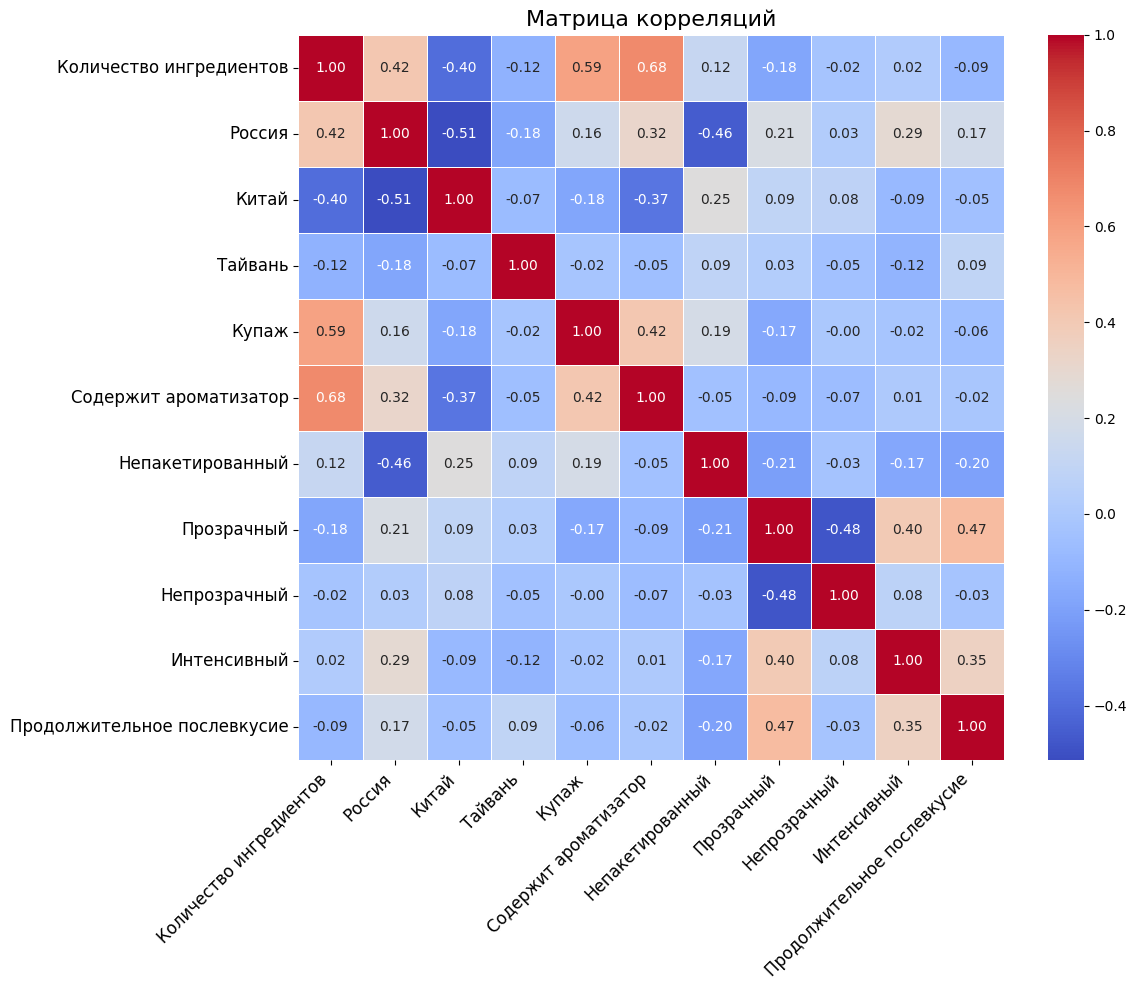

         VIF                      Feature
0   8.009527      Количество ингредиентов
1   5.003376                       Россия
2   2.094078                        Китай
3   1.162336                      Тайвань
4   2.604233                        Купаж
5   3.839949        Содержит ароматизатор
6   4.171992             Непакетированный
7   8.866668                   Прозрачный
8   1.743430                 Непрозрачный
9   3.136022                  Интенсивный
10  3.217694  Продолжительное послевкусие
Нет признаков с большим VIF


In [ ]:
#Проверка мультиколлиниарности
check_multicollinearity(X)

In [ ]:
# отбор регрессоров с помошью lasso. Отбираем таким образом, потом сравниваем с набором переменных, отобранным по AIC. Если они схожи, значит модель устойчива
model_lasso = sm.OLS(log_y, X)
lasso_result = model_lasso.fit_regularized(alpha=0.1, L1_wt=1.0)  # L1_{wt} = 1 -> Lasso

X_noconst = X.drop('const', axis=1)
selected_features_lasso = X_noconst.columns[lasso_result.params[1:] != 0]

print("Отобранные Lasso переменные:")
for variable in selected_features_lasso:
    print(f'{variable}')

Отобранные Lasso переменные:
Количество ингредиентов
Прозрачный


In [ ]:
print('Совпадение отобранных переменных:', set(selected_features_aic) == set(selected_features_lasso))
print('Переменные только в Lasso:', set(selected_features_aic) - set(selected_features_lasso))
print('Переменные только в AIC:', set(selected_features_lasso) - set(selected_features_aic))

Совпадение отобранных переменных: False
Переменные только в Lasso: {'Интенсивный', 'Китай', 'const', 'Тайвань', 'Непакетированный', 'Непрозрачный', 'Россия', 'Содержит ароматизатор', 'Продолжительное послевкусие'}
Переменные только в AIC: {'Количество ингредиентов'}


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Цена за грамм (₽/г)   R-squared:                       0.320
Model:                             OLS   Adj. R-squared:                  0.288
Method:                  Least Squares   F-statistic:                     11.89
Date:                 Wed, 07 May 2025   Prob (F-statistic):           1.56e-17
Time:                         11:23:16   Log-Likelihood:                -163.25
No. Observations:                  240   AIC:                             350.5
Df Residuals:                      228   BIC:                             392.3
Df Model:                           11                                         
Covariance Type:                   HC3                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.7092      0.116     14.762      0.000       1.482       1.936
Количество ингредиентов         0.0233      0.016      1.452      0.147      -0.008       0.055
Россия                         -0.1792      0.089     -2.013      0.044      -0.354      -0.005
Китай                           0.3219      0.136      2.364      0.018       0.055       0.589
Тайвань                         0.5347      0.348      1.535      0.125      -0.148       1.217
Купаж                          -0.1200      0.089     -1.355      0.175      -0.294       0.054
Содержит ароматизатор          -0.1741      0.078     -2.222      0.026      -0.328      -0.021
Непакетированный               -0.3939      0.090     -4.373      0.000      -0.570      -0.217
Прозрачный                      0.3865      0.122      3.179      0.001       0.148       0.625
Непрозрачный                    0.2825      0.187      1.514      0.130      -0.083       0.648
Интенсивный                    -0.2311      0.086     -2.696      0.007      -0.399      -0.063
Продолжительное послевкусие     0.1755      0.079      2.230      0.026       0.021       0.330
==============================================================================
Omnibus:                        3.885   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                4.223
Skew:                           0.137   Prob(JB):                        0.121
Kurtosis:                       3.589   Cond. No.                         36.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

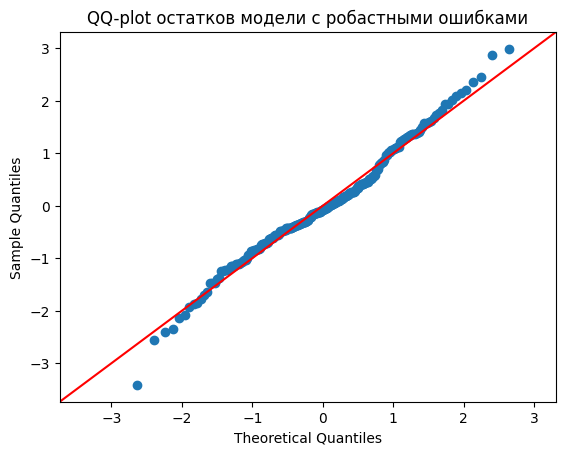

In [ ]:
# график для анализа нормальности остатков
residuals = model.resid

# Построение QQ-plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ-plot остатков модели с робастными ошибками')
plt.show()

In [ ]:
model_start.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Цена за грамм (₽/г)   R-squared:                       0.320
Model:                             OLS   Adj. R-squared:                  0.288
Method:                  Least Squares   F-statistic:                     9.771
Date:                 Wed, 07 May 2025   Prob (F-statistic):           1.88e-14
Time:                         11:23:16   Log-Likelihood:                -163.25
No. Observations:                  240   AIC:                             350.5
Df Residuals:                      228   BIC:                             392.3
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.7092      0.128     13.387      0.000       1.458       1.961
Количество ингредиентов         0.0233      0.018      1.262      0.208      -0.013       0.060
Россия                         -0.1792      0.100     -1.799      0.073      -0.376       0.017
Китай                           0.3219      0.112      2.872      0.004       0.101       0.543
Тайвань                         0.5347      0.216      2.470      0.014       0.108       0.961
Купаж                          -0.1200      0.082     -1.470      0.143      -0.281       0.041
Содержит ароматизатор          -0.1741      0.089     -1.963      0.051      -0.349       0.001
Непакетированный               -0.3939      0.095     -4.154      0.000      -0.581      -0.207
Прозрачный                      0.3865      0.120      3.211      0.002       0.149       0.624
Непрозрачный                    0.2825      0.161      1.755      0.081      -0.035       0.600
Интенсивный                    -0.2311      0.077     -3.009      0.003      -0.382      -0.080
Продолжительное послевкусие     0.1755      0.077      2.283      0.023       0.024       0.327
==============================================================================
Omnibus:                        3.885   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                4.223
Skew:                           0.137   Prob(JB):                        0.121
Kurtosis:                       3.589   Cond. No.                         36.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

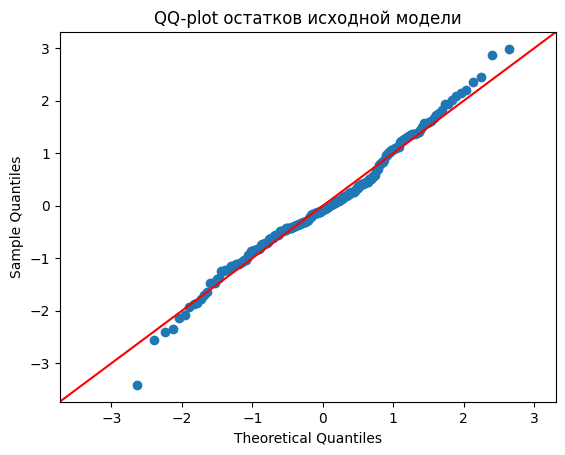

In [ ]:
# график для анализа нормальности остатков исходной модели
residuals_start = model_start.resid

# Построение QQ-plot
sm.qqplot(residuals_start, line='45', fit=True)
plt.title('QQ-plot остатков исходной модели')
plt.savefig("qq.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# тест Шапиро-Уилка на нормальность ошибок для исходной модели
stat, p_value = shapiro(residuals_start)
print(f"p-value в тесте Шапиро-Уилка на нормальность остатков = {round(p_value, 3)}")

p-value в тесте Шапиро-Уилка на нормальность остатков = 0.033


In [ ]:
boot_ci = bootstrap_ols(X, log_y)
print("95% доверительные интервалы коэффициентов:\n")
boot_ci

95% доверительные интервалы коэффициентов:



,const,Количество ингредиентов,Россия,Китай,Тайвань,Купаж,Содержит ароматизатор,Непакетированный,Прозрачный,Непрозрачный,Интенсивный,Продолжительное послевкусие
0.025,1.491656,-0.009563,-0.348971,0.062208,-0.075191,-0.284691,-0.320348,-0.563229,0.129364,-0.0963,-0.393803,0.022731
0.975,1.919632,0.054592,-0.019874,0.590605,1.159824,0.040920,-0.030155,-0.219991,0.610764,0.6147,-0.053221,0.340669


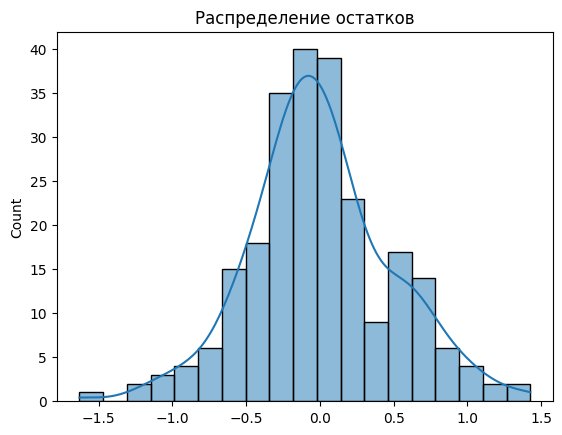

In [ ]:
sns.histplot(residuals, kde=True)
plt.title('Распределение остатков')
plt.show()

In [ ]:
# тест Шапиро-Уилка на нормальность ошибок
stat, p_value = shapiro(residuals)
print(f"p-value в тесте Шапиро-Уилка на нормальность остатков = {round(p_value, 3)}")

p-value в тесте Шапиро-Уилка на нормальность остатков = 0.033


In [ ]:
# Парный бутстрап, так как остатки ненормальны
bootstrap_results = paired_bootstrap_ols(X, log_y, n_bootstrap=2000)
bootstrap_results

Бутстрап: 100%|██████████| 2000/2000 [00:02<00:00, 912.69it/s]


,coef,ci_lower,ci_upper
const,1.709162,1.493529,1.929037
Количество ингредиентов,0.023309,-0.007945,0.051485
Россия,-0.179218,-0.346439,-0.012255
Китай,0.321934,0.059708,0.588951
Тайвань,0.534715,-0.174765,1.178464
Купаж,-0.120003,-0.272800,0.056820
Содержит ароматизатор,-0.174103,-0.312875,-0.016042
Непакетированный,-0.393909,-0.560874,-0.212935
Прозрачный,0.386503,0.161987,0.625058
Непрозрачный,0.282540,-0.058085,0.616215


In [ ]:
# Сравнение бутстрап ДИ и исходных ДИ модели
ci_classic = model.conf_int()
classic_width = ci_classic[1] - ci_classic[0]

bootstrap_width = bootstrap_results['ci_upper'] - bootstrap_results['ci_lower']

# Таблица сравнения
comparison = pd.DataFrame({
    'Классический_ДИ_ширина': classic_width,
    'Бутстрап_ДИ_ширина': bootstrap_width,
    'Разница_%': (bootstrap_width - classic_width) / classic_width * 100
})
comparison

,Классический_ДИ_ширина,Бутстрап_ДИ_ширина,Разница_%
const,0.453862,0.435509,-4.043908
Количество ингредиентов,0.062927,0.059430,-5.557700
Россия,0.349005,0.334184,-4.246622
Китай,0.533822,0.529242,-0.857812
Тайвань,1.365568,1.353229,-0.903610
Купаж,0.347115,0.329620,-5.040263
Содержит ароматизатор,0.307087,0.296834,-3.338735
Непакетированный,0.353063,0.347939,-1.451538
Прозрачный,0.476602,0.463071,-2.839159
Непрозрачный,0.731629,0.674300,-7.835694


In [ ]:
overlap = np.minimum(bootstrap_results['ci_upper'], ci_classic[1]) - np.maximum(bootstrap_results['ci_lower'], ci_classic[0])
overlap_ratio = overlap / classic_width * 100
print("Процент перекрытия ДИ:", overlap_ratio)

Процент перекрытия ДИ: const                          95.956092
Количество ингредиентов        94.442300
Россия                         95.753378
Китай                          99.122359
Тайвань                        97.141506
Купаж                          94.019223
Содержит ароматизатор          95.190153
Непакетированный               97.290439
Прозрачный                     97.107682
Непрозрачный                   92.164306
Интенсивный                    98.052279
Продолжительное послевкусие    98.419636
dtype: float64


In [ ]:
# Сбор остатков
bootstrap_residuals = collect_bootstrap_residuals(X, log_y, n_bootstrap=2000)

In [ ]:
#qqplot(bootstrap_residuals, line='45', fit=True)
#plt.title('Q-Q plot агрегированных бутстрап-остатков')
#plt.show()

## Анализ dffits + dfbeta

In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(model_start)

dfbeta = influence.dfbeta
dffits = influence.dffits[0]

influence_summary = pd.DataFrame({
    'observation': range(len(X)),
    'max_abs_dfbeta': np.max(np.abs(dfbeta), axis=1),  # Максимум по всем регрессорам
    'abs_dffits': np.abs(dffits)
})

In [ ]:
# Пороговые значения
dfbeta_threshold = 2 / np.sqrt(len(X))
dffits_threshold = 2 * np.sqrt(len(X.columns) / np.sqrt(len(X)))

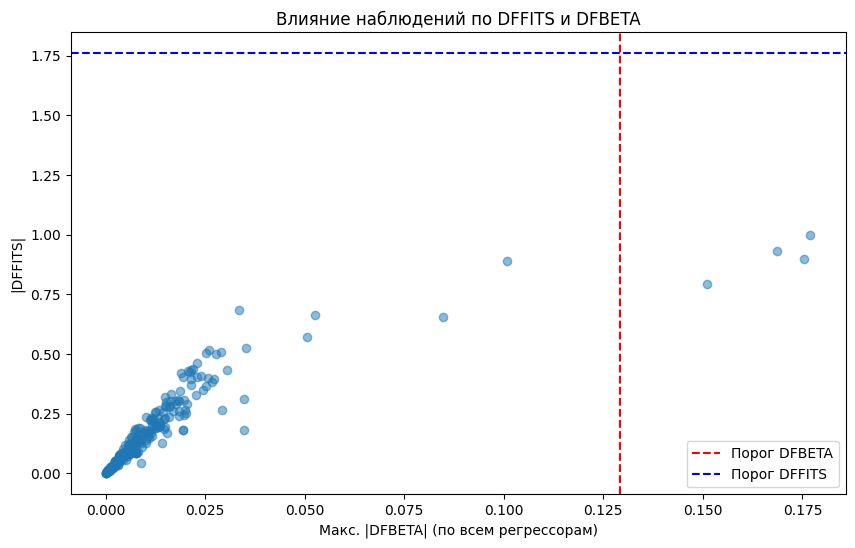

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(
    influence_summary['max_abs_dfbeta'],
    influence_summary['abs_dffits'],
    alpha=0.5
)
plt.axvline(dfbeta_threshold, color='red', linestyle='--', label='Порог DFBETA')
plt.axhline(dffits_threshold, color='blue', linestyle='--', label='Порог DFFITS')
plt.xlabel('Макс. |DFBETA| (по всем регрессорам)')
plt.ylabel('|DFFITS|')
plt.title('Влияние наблюдений по DFFITS и DFBETA')
plt.legend()
plt.savefig("fitsbeta.png", dpi=300, bbox_inches='tight')
plt.show()

Влияние на коэффициенты есть, но нет влияния на предсказания, так как нет точек, превышающих порог по dffits. Все наблюдения, превышающие порог по dfbeta (их всего 4) относятся к регрессору "Китай". Доверительный иньервал для коэффициента, построенный бутстрапом, не включает 0, поэтому коэффициент значим. Мы решили оставить эти наблюдения.

# Квантильная регрессия

In [ ]:
np.random.seed(1001)
quantiles = [0.1, 0.5, 0.9]

for q in quantiles:
    quant_model = QuantReg(log_y, X).fit(q=q)
    print(f"\n=== Квантильная регрессия для q = {q} ===")
    print(quant_model.summary())
    print("\n" + "=" * 80 + "\n")


=== Квантильная регрессия для q = 0.1 ===
                          QuantReg Regression Results                          
Dep. Variable:     Цена за грамм (₽/г)   Pseudo R-squared:               0.1499
Model:                        QuantReg   Bandwidth:                      0.3999
Method:                  Least Squares   Sparsity:                        1.365
Date:                 Wed, 07 May 2025   No. Observations:                  240
Time:                         11:23:24   Df Residuals:                      228
                                         Df Model:                           11
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.3099      0.102     12.792      0.000       1.108       1.512
Количество ингредиентов         0.0413      0.020      2.071      0.040       0.002       0.081
Россия       

In [ ]:
np.random.seed(1001)

quantiles = [0.1, 0.5, 0.9]
models_mq = []  # здесь будем хранить финальные модели с правильными SE
n_boot = 50

# Получаем имена предикторов (включая intercept, если он есть)
predictors = X.columns.tolist()

# Бутстрэп-процедура
print("Запуск бутстрэп-процедуры...")
bootstrap_coefs = {q: [] for q in quantiles}
for _ in tqdm(range(n_boot), desc="Прогресс"):
    # Генерируем бутстрап-выборку
    bootstrap_idx = np.random.choice(len(log_y), size=len(log_y), replace=True)
    bootstrap_X = X.iloc[bootstrap_idx]
    bootstrap_log_y = log_y.iloc[bootstrap_idx]

    for q in quantiles:
        model_q = QuantReg(bootstrap_log_y, bootstrap_X).fit(q=q)
        bootstrap_coefs[q].append(model_q.params)

for q in quantiles:
    # Основная модель
    main_model = QuantReg(log_y, X).fit(q=q)

    # Рассчитываем бутстрап-стандартные ошибки
    coefs = pd.DataFrame(bootstrap_coefs[q])
    bse = coefs.std()

    # Создаем новую модель с бутстрап-SE
    main_model.bse = bse.values  # используем values, так как bse это Series
    models_mq.append(main_model)

# Функция для создания красивой таблицы
def create_results_table(q):
    main_model = QuantReg(log_y, X).fit(q=q)
    coefs_df = pd.DataFrame(bootstrap_coefs[q])
    bse = coefs_df.std()

    results = pd.DataFrame({
        'factor': predictors,
        'coeff': main_model.params.values,
        'std err (boot)': bse.values,
        '95% CI low': main_model.params - 1.96*bse,
        '95% CI high': main_model.params + 1.96*bse,
        't-stat': main_model.params / bse,
        'p-value': [2*(1-stats.norm.cdf(abs(t))) for t in (main_model.params / bse)]
    })

    # Форматирование чисел
    for col in results.columns[1:]:
        results[col] = results[col].apply(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)

    return results

# Вывод результатов для каждого квантиля
for q in quantiles:
    print(f"\n{'='*80}")
    print(f"=== Результаты квантильной регрессии для квантиля {q} (бутстрэп, n={n_boot}) ===")
    print(f"{'='*80}\n")

    results_table = create_results_table(q)
    display(results_table)

    # Также выводим оригинальную summary для сравнения
    print("\nОригинальная модель без бутстрэп-стандартных ошибок:")
    orig_model = QuantReg(log_y, X).fit(q=q)
    print(orig_model.summary())
    print("\n" + "="*80 + "\n")

Запуск бутстрэп-процедуры...


Прогресс:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
Прогресс: 100%|██████████| 50/50 [00:04<00:00, 11.39it/s]



=== Результаты квантильной регрессии для квантиля 0.1 (бутстрэп, n=50) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
const,const,1.3099,0.1242,1.0664,1.5533,10.5465,0.0000
Количество ингредиентов,Количество ингредиентов,0.0413,0.0177,0.0065,0.0760,2.3262,0.0200
Россия,Россия,-0.1821,0.1012,-0.3804,0.0162,-1.7996,0.0719
Китай,Китай,-0.2762,0.2373,-0.7413,0.1888,-1.1641,0.2444
Тайвань,Тайвань,0.2635,0.3272,-0.3778,0.9049,0.8053,0.4206
Купаж,Купаж,-0.1875,0.1031,-0.3895,0.0145,-1.8196,0.0688
Содержит ароматизатор,Содержит ароматизатор,0.0071,0.0605,-0.1115,0.1257,0.1172,0.9067
Непакетированный,Непакетированный,-0.4298,0.0893,-0.6049,-0.2548,-4.8136,0.0000
Прозрачный,Прозрачный,0.1791,0.1258,-0.0675,0.4257,1.4234,0.1546
Непрозрачный,Непрозрачный,0.1011,0.2976,-0.4822,0.6844,0.3397,0.7341



Оригинальная модель без бутстрэп-стандартных ошибок:
                          QuantReg Regression Results                          
Dep. Variable:     Цена за грамм (₽/г)   Pseudo R-squared:               0.1499
Model:                        QuantReg   Bandwidth:                      0.3999
Method:                  Least Squares   Sparsity:                        1.365
Date:                 Wed, 07 May 2025   No. Observations:                  240
Time:                         11:23:29   Df Residuals:                      228
                                         Df Model:                           11
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.3099      0.102     12.792      0.000       1.108       1.512
Количество ингредиентов         0.0413      0.020      2.071      0.040       0.002       0.081
Ро

,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
const,const,1.5231,0.1266,1.2749,1.7713,12.0277,0.0000
Количество ингредиентов,Количество ингредиентов,0.0209,0.0151,-0.0087,0.0504,1.3850,0.1661
Россия,Россия,-0.2596,0.0835,-0.4232,-0.0960,-3.1101,0.0019
Китай,Китай,0.3441,0.1901,-0.0285,0.7167,1.8099,0.0703
Тайвань,Тайвань,0.6557,0.4470,-0.2205,1.5319,1.4668,0.1424
Купаж,Купаж,-0.0414,0.0844,-0.2068,0.1240,-0.4904,0.6238
Содержит ароматизатор,Содержит ароматизатор,-0.0982,0.1001,-0.2944,0.0981,-0.9803,0.3269
Непакетированный,Непакетированный,-0.3320,0.1015,-0.5310,-0.1330,-3.2701,0.0011
Прозрачный,Прозрачный,0.5055,0.1656,0.1809,0.8302,3.0522,0.0023
Непрозрачный,Непрозрачный,0.5210,0.2487,0.0336,1.0084,2.0952,0.0362



Оригинальная модель без бутстрэп-стандартных ошибок:
                          QuantReg Regression Results                          
Dep. Variable:     Цена за грамм (₽/г)   Pseudo R-squared:               0.2233
Model:                        QuantReg   Bandwidth:                      0.2961
Method:                  Least Squares   Sparsity:                       0.9385
Date:                 Wed, 07 May 2025   No. Observations:                  240
Time:                         11:23:30   Df Residuals:                      228
                                         Df Model:                           11
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.5231      0.122     12.460      0.000       1.282       1.764
Количество ингредиентов         0.0209      0.018      1.179      0.240      -0.014       0.056
Ро

,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
const,const,2.3479,0.2696,1.8194,2.8764,8.7074,0.0000
Количество ингредиентов,Количество ингредиентов,0.0130,0.0421,-0.0695,0.0954,0.3079,0.7582
Россия,Россия,-0.1734,0.1646,-0.4959,0.1491,-1.0537,0.2920
Китай,Китай,0.6246,0.1673,0.2967,0.9526,3.7327,0.0002
Тайвань,Тайвань,0.8404,0.3077,0.2374,1.4435,2.7315,0.0063
Купаж,Купаж,-0.0613,0.1536,-0.3624,0.2397,-0.3992,0.6897
Содержит ароматизатор,Содержит ароматизатор,-0.3101,0.1733,-0.6498,0.0295,-1.7899,0.0735
Непакетированный,Непакетированный,-0.5608,0.1503,-0.8554,-0.2661,-3.7303,0.0002
Прозрачный,Прозрачный,0.4512,0.2879,-0.1131,1.0156,1.5673,0.1170
Непрозрачный,Непрозрачный,0.2066,0.3658,-0.5103,0.9236,0.5649,0.5721



Оригинальная модель без бутстрэп-стандартных ошибок:
                          QuantReg Regression Results                          
Dep. Variable:     Цена за грамм (₽/г)   Pseudo R-squared:               0.2866
Model:                        QuantReg   Bandwidth:                      0.3280
Method:                  Least Squares   Sparsity:                        2.146
Date:                 Wed, 07 May 2025   No. Observations:                  240
Time:                         11:23:30   Df Residuals:                      228
                                         Df Model:                           11
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           2.3479      0.175     13.441      0.000       2.004       2.692
Количество ингредиентов         0.0130      0.026      0.508      0.612      -0.037       0.063
Ро

In [ ]:
variables = [col for col in X.columns if col != 'const']
quantile_pairs = list(itertools.combinations(range(len(quantiles)), 2))

all_results = []

print("\n" + "="*80)
print("НАЧАЛО АНАЛИЗА РАЗЛИЧИЙ МЕЖДУ КВАНТИЛЯМИ")
print("="*80 + "\n")

for variable in variables:
    print(f"\n{'-'*40}")
    print(f"Анализ переменной: {variable}")
    print(f"{'-'*40}")

    for q1_idx, q2_idx in quantile_pairs:
        result = test_coefficient_equality(
            models_mq=models_mq,
            bootstrap_coefs=bootstrap_coefs,
            variable=variable,
            q1_idx=q1_idx,
            q2_idx=q2_idx
        )
        all_results.append(result)
        print("\n" + "-"*60 + "\n")

results_df = pd.DataFrame(all_results)

significant_results = results_df[results_df['reject_null']]
if not significant_results.empty:
    print("\nПеременные со значимыми различиями между квантилями:")
    display(significant_results[['variable', 'q1', 'q2', 'difference', 'p_value']])
else:
    print("\nНе найдено переменных со значимыми различиями между квантилями")


НАЧАЛО АНАЛИЗА РАЗЛИЧИЙ МЕЖДУ КВАНТИЛЯМИ


----------------------------------------
Анализ переменной: Количество ингредиентов
----------------------------------------

Тест равенства коэффициентов для 'Количество ингредиентов' между квантилями 0.1 и 0.5:
Коэффициент для q=0.1: 0.0413 (SE: 0.0177)
Коэффициент для q=0.5: 0.0209 (SE: 0.0151)
Разность: 0.0204 (SE разности: 0.0233)
Wald statistic: 0.8768
P-value: 0.3806

Вывод: Не отвергаем H0 (p=0.3806 >= 0.05) - нет доказательств различий.
Эффект переменной 'Количество ингредиентов' одинаков для квантилей 0.1 и 0.5.

------------------------------------------------------------


Тест равенства коэффициентов для 'Количество ингредиентов' между квантилями 0.1 и 0.9:
Коэффициент для q=0.1: 0.0413 (SE: 0.0177)
Коэффициент для q=0.9: 0.0130 (SE: 0.0421)
Разность: 0.0283 (SE разности: 0.0457)
Wald statistic: 0.6196
P-value: 0.5355

Вывод: Не отвергаем H0 (p=0.5355 >= 0.05) - нет доказательств различий.
Эффект переменной 'Количество ингредиент

,variable,q1,q2,difference,p_value
6,Китай,0.1,0.5,-0.620312,0.041333
7,Китай,0.1,0.9,-0.900857,0.001918


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


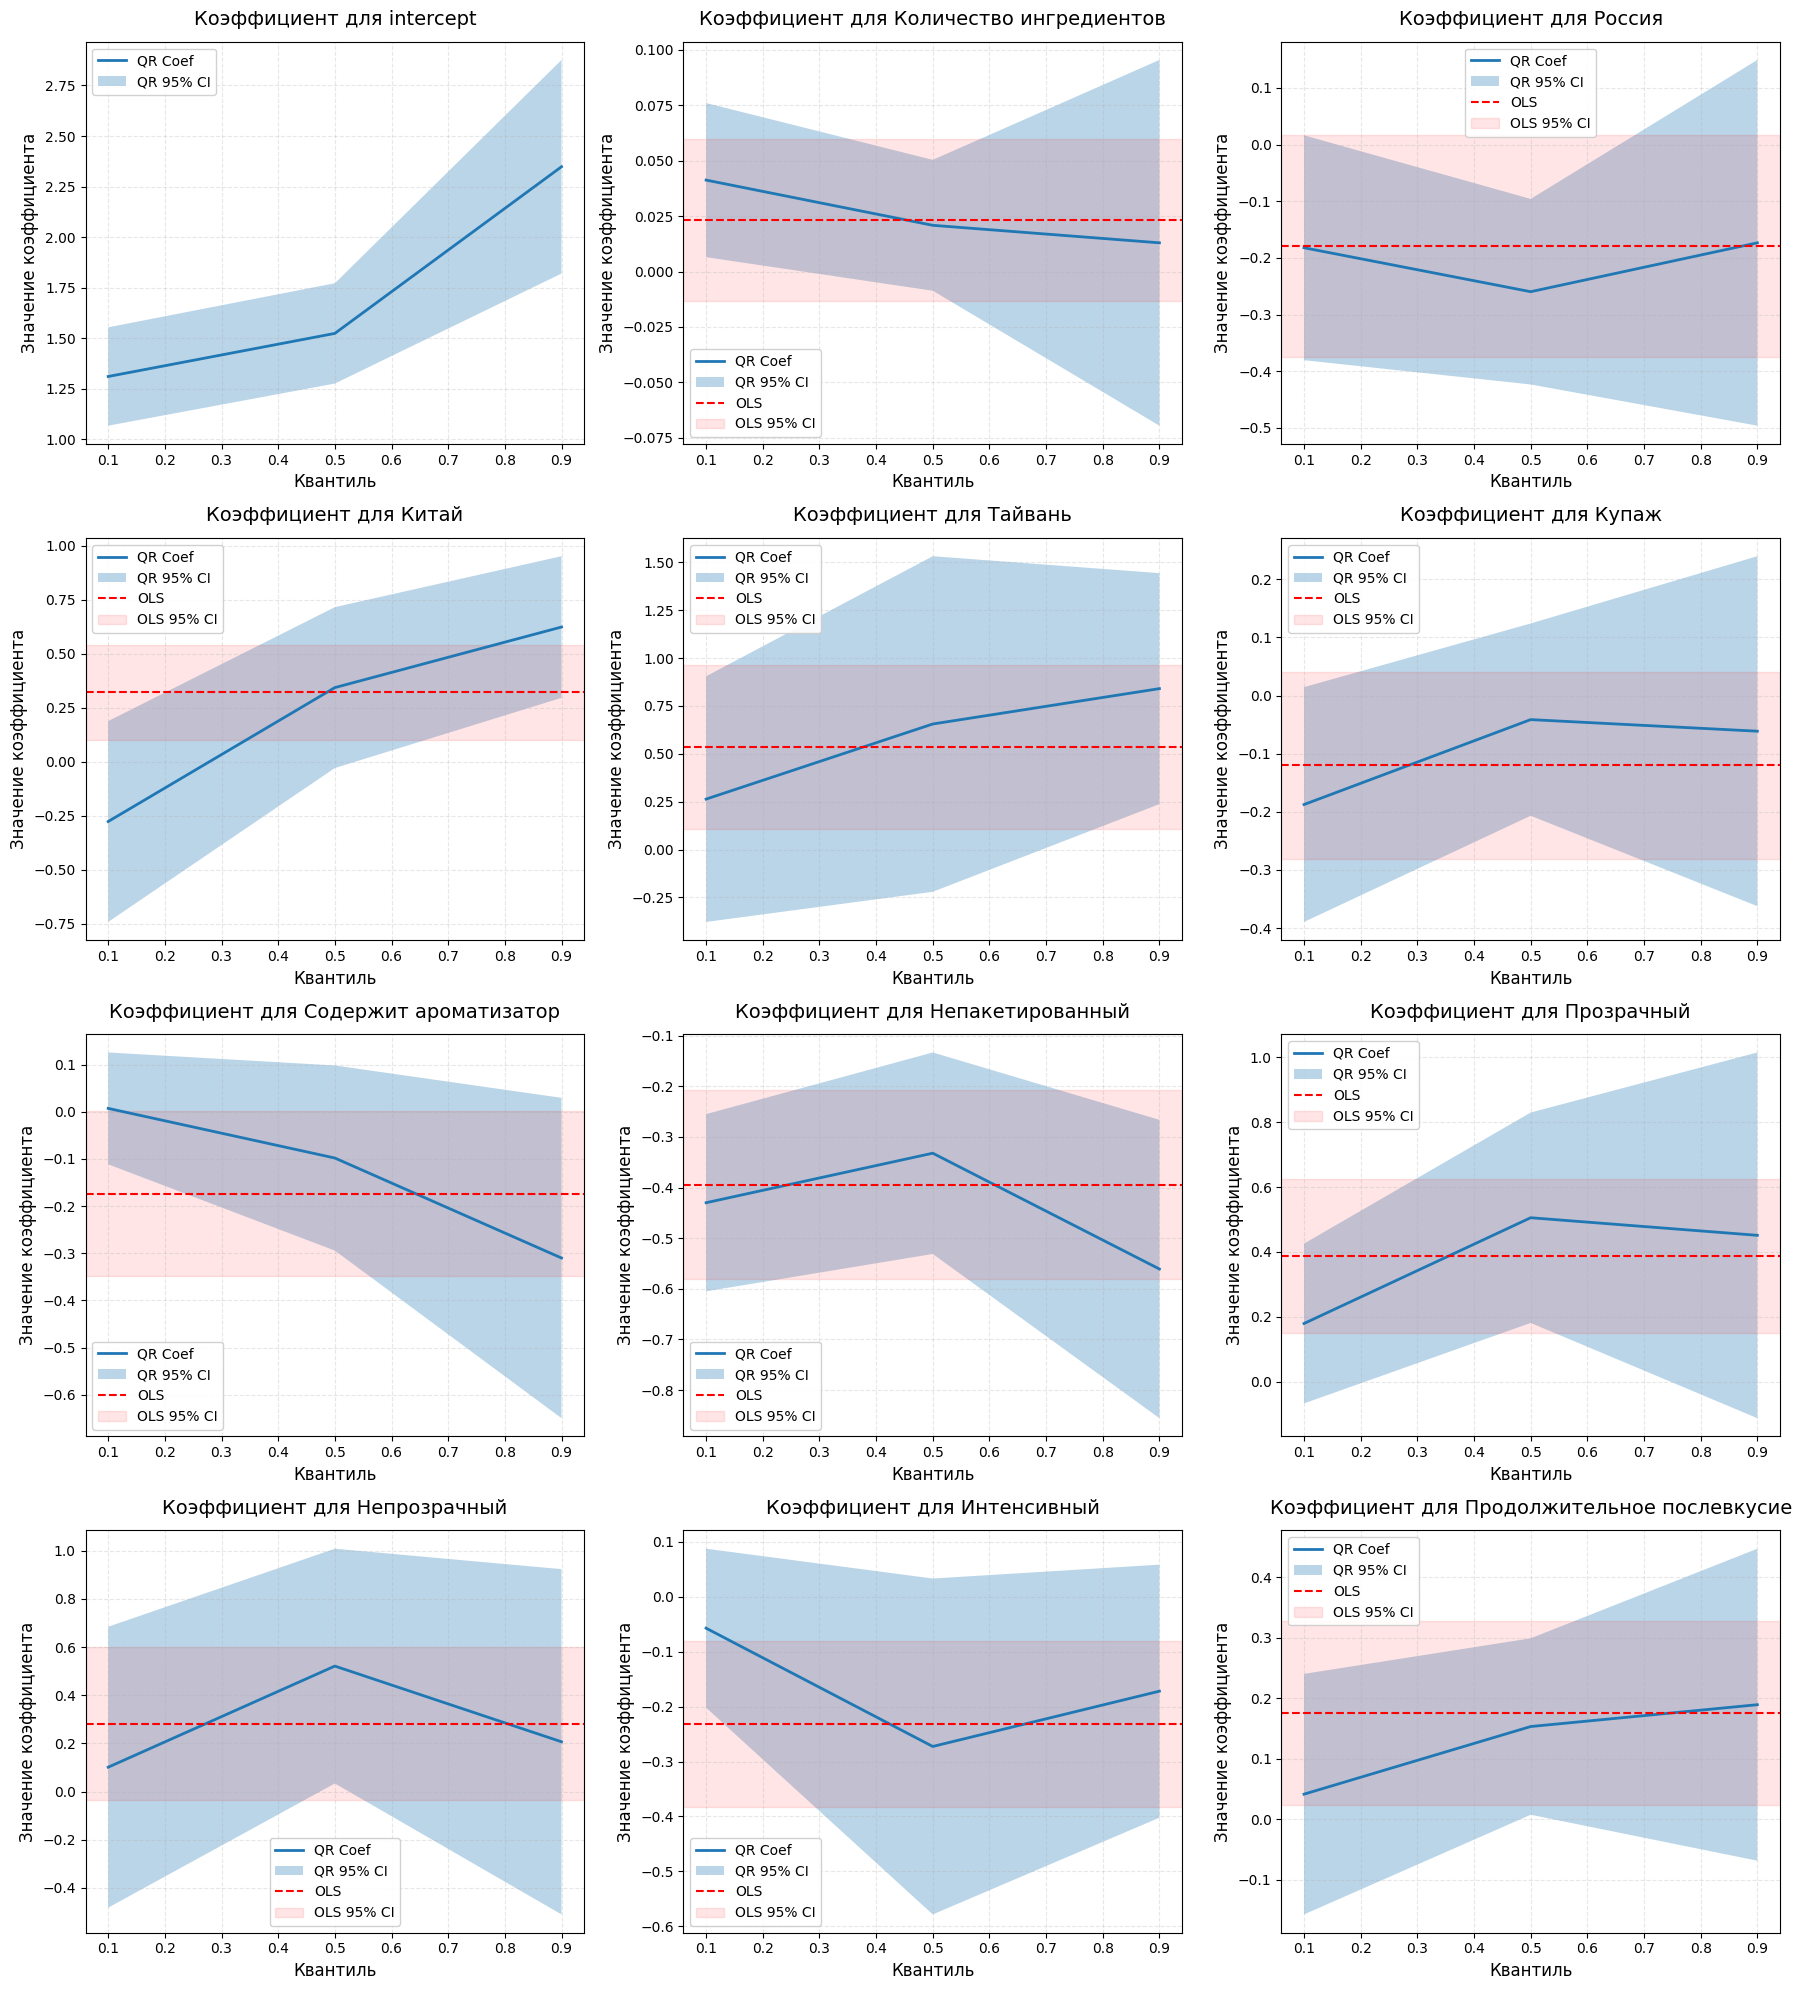

In [ ]:
# Загрузка данных
data = pd.read_csv('chai.csv')
X_q = data[['Количество ингредиентов', 'Россия', 'Китай', 'Тайвань', 'Купаж',
          'Содержит ароматизатор', 'Непакетированный', 'Прозрачный',
          'Непрозрачный', 'Интенсивный', 'Продолжительное послевкусие']]
y_q = data['Цена за грамм (₽/г)']
log_y_q = np.log(y_q)
X_q = sm.add_constant(X_q)

ols_model = sm.OLS(log_y_q, X_q).fit()
ols_conf_int = ols_model.conf_int()

quantiles_mq = [0.1, 0.5, 0.9]
n_boot = 50
models_mq = []

np.random.seed(1001)
bootstrap_coefs = {q: [] for q in quantiles_mq}

for _ in range(n_boot):
    bootstrap_idx = np.random.choice(len(log_y_q), size=len(log_y_q), replace=True)
    bootstrap_X = X_q.iloc[bootstrap_idx]
    bootstrap_log_y_q = log_y_q.iloc[bootstrap_idx]

    for q in quantiles_mq:
        model_q = QuantReg(bootstrap_log_y_q, bootstrap_X).fit(q=q)
        bootstrap_coefs[q].append(model_q.params)

for q in quantiles_mq:
    main_model = QuantReg(log_y_q, X_q).fit(q=q)
    coefs = pd.DataFrame(bootstrap_coefs[q])
    main_model.bse = coefs.std().values
    models_mq.append(main_model)

plot_data = pd.DataFrame()
predictors = X_q.columns.tolist()

for q in quantiles_mq:
    model_q = models_mq[quantiles_mq.index(q)]
    coef_dict = {'quantile': q}

    for pred in predictors:
        coef_dict[pred] = model_q.params[pred]
        coef_dict[f'{pred}_lower'] = model_q.params[pred] - 1.96 * model_q.bse[predictors.index(pred)]
        coef_dict[f'{pred}_upper'] = model_q.params[pred] + 1.96 * model_q.bse[predictors.index(pred)]

    plot_data = pd.concat([plot_data, pd.DataFrame(coef_dict, index=[0])], ignore_index=True)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20))
axes = axes.flatten()

for i, pred in enumerate(predictors):
    ax = axes[i]
    ols_pred_name = pred if pred != 'const' else 'Intercept'

    sns.lineplot(data=plot_data, x='quantile', y=pred, ax=ax,
                label='QR Coef', linewidth=2)
    ax.fill_between(plot_data['quantile'],
                   plot_data[f'{pred}_lower'],
                   plot_data[f'{pred}_upper'],
                   alpha=0.3, label='QR 95% CI')

    if ols_pred_name in ols_model.params:
        ax.axhline(ols_model.params[ols_pred_name],
                  color='red', linestyle='--',
                  linewidth=1.5, label='OLS')
        ax.axhspan(ols_conf_int.loc[ols_pred_name, 0],
                  ols_conf_int.loc[ols_pred_name, 1],
                  color='red', alpha=0.1, label='OLS 95% CI')

    pred_name = 'intercept' if pred == 'const' else pred
    ax.set_title(f'Коэффициент для {pred_name}', fontsize=14, pad=12)
    ax.set_xlabel('Квантиль', fontsize=12)
    ax.set_ylabel('Значение коэффициента', fontsize=12)
    ax.legend(fontsize=10, framealpha=0.9)
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(len(predictors), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Предсказание стоимости товара

In [ ]:
df['Предсказанная цена за грамм'] = model.predict(X)
df['Предсказанная цена за грамм'].describe()
df.head(10)

,Название,Цена за грамм (₽/г),Количество ингредиентов,Россия,Китай,Индия,Тайвань,Шри-Ланка,ЮАР,Купаж,...,Непрозрачный,Интенсивный,Неинтенсивный,Терпкость,Кислотность,Продолжительное послевкусие,Горечь,Сладкость,Интенсивность послевкусия,Предсказанная цена за грамм
0,АЛТАЙСКИЙ БАЛЬЗАМ,4.652000,3,1,0,0,0,0,0,1,...,0,1,0,1,1,1,0,1,2,1.416922
1,АЛТАЙСКИЙ ИВАН-ЧАЙ С САГАН ДАЙЛЯ И БРУСНИКОЙ,9.940000,8,1,0,0,0,0,0,1,...,0,0,1,3,1,1,1,0,6,1.764527
2,АРОМАТНЫЙ ЖАСМИН,5.928000,1,0,1,0,0,0,0,1,...,0,0,1,2,1,0,0,0,5,1.926997
3,АССАМ №12,2.728000,1,0,0,1,0,0,0,0,...,0,1,0,3,1,1,0,0,2,1.669525
4,АССАМ №24,2.426667,1,0,0,1,0,0,0,0,...,0,1,0,3,1,1,0,0,2,1.669525
5,АССАМ МОКАЛБАРИ,7.396000,1,0,0,1,0,0,0,0,...,0,1,0,1,1,0,0,1,2,1.494004
6,АССАМ ЦВЕТОК ВЕСНЫ,3.944000,1,0,0,1,0,0,0,0,...,0,1,0,3,2,1,0,0,2,1.669525
7,ГЛИНТВЕЙН,4.172000,12,1,0,0,0,0,0,1,...,0,1,0,3,1,1,0,0,2,1.452598
8,ГРАФ ОРЛОФФ,4.440000,6,1,0,0,0,0,0,0,...,0,1,0,2,1,1,0,0,2,1.432748
9,ГРЕЧИШНЫЙ ЧАЙ КУ ЦЯО,3.696000,1,0,0,0,0,0,0,0,...,0,0,1,1,1,1,0,0,2,1.900587


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Цена за грамм (₽/г)   R-squared:                       0.320
Model:                             OLS   Adj. R-squared:                  0.288
Method:                  Least Squares   F-statistic:                     11.89
Date:                 Wed, 07 May 2025   Prob (F-statistic):           1.56e-17
Time:                         11:23:39   Log-Likelihood:                -163.25
No. Observations:                  240   AIC:                             350.5
Df Residuals:                      228   BIC:                             392.3
Df Model:                           11                                         
Covariance Type:                   HC3                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.7092      0.116     14.762      0.000       1.482       1.936
Количество ингредиентов         0.0233      0.016      1.452      0.147      -0.008       0.055
Россия                         -0.1792      0.089     -2.013      0.044      -0.354      -0.005
Китай                           0.3219      0.136      2.364      0.018       0.055       0.589
Тайвань                         0.5347      0.348      1.535      0.125      -0.148       1.217
Купаж                          -0.1200      0.089     -1.355      0.175      -0.294       0.054
Содержит ароматизатор          -0.1741      0.078     -2.222      0.026      -0.328      -0.021
Непакетированный               -0.3939      0.090     -4.373      0.000      -0.570      -0.217
Прозрачный                      0.3865      0.122      3.179      0.001       0.148       0.625
Непрозрачный                    0.2825      0.187      1.514      0.130      -0.083       0.648
Интенсивный                    -0.2311      0.086     -2.696      0.007      -0.399      -0.063
Продолжительное послевкусие     0.1755      0.079      2.230      0.026       0.021       0.330
==============================================================================
Omnibus:                        3.885   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                4.223
Skew:                           0.137   Prob(JB):                        0.121
Kurtosis:                       3.589   Cond. No.                         36.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [ ]:
new_data = pd.DataFrame({
    'const': [1],
    'Количество ингредиентов': [5],
    'Россия': [1],
    'Китай': [0],
    'Тайвань': [0],
    'Купаж': [0],
    'Содержит ароматизатор': [1],
    'Непакетированный': [0],
    'Прозрачный': [1],
    'Непрозрачный': [0],
    'Интенсивный': [0],
    'Продолжительное послевкусие': [1]
})

new_data = new_data[X.columns]
log_pred = model.predict(new_data)
predicted_price = np.exp(log_pred)

print(f"Прогнозируемая цена за грамм: {predicted_price[0]:.2f} ₽/г")

Прогнозируемая цена за грамм: 7.65 ₽/г


In [ ]:
predictions = model.get_prediction(new_data)
pred_summary = predictions.summary_frame(alpha=0.05)
predicted_price = np.exp(pred_summary['mean'])[0]
lower_bound = np.exp(pred_summary['mean_ci_lower'])[0]
upper_bound = np.exp(pred_summary['mean_ci_upper'])[0]

print(f"Прогнозируемая цена за грамм: {predicted_price:.2f} ₽/г")
print(f"95% доверительный интервал: [{lower_bound:.2f}, {upper_bound:.2f}] ₽/г")

Прогнозируемая цена за грамм: 7.65 ₽/г
95% доверительный интервал: [6.31, 9.28] ₽/г
